# 0.0 CONFIGURAÇÕES INICIAIS

### 0.1 Montando o Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0.2. Instalação de bibliotecas

In [15]:
!pip install inflection
!pip install dython
!pip install boruta

     |████████████████████████████████| 61kB 1.8MB/s 


### 0.3 Importação de Bibliotecas

In [17]:
import pandas as pd
import inflection #Inflection is a string transformation library
import math
import numpy as np
import datetime
import random
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import display, HTML
from tabulate import tabulate
from scipy import stats
from dython.nominal import associations #correlação entre variáveis categóricas

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn.model_selection import TimeSeriesSplit

from boruta import BorutaPy
import xgboost as xgb

### 0.4 Funções Auxiliares

In [195]:
# Para configurar as imagens:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set() 
    
jupyter_settings();

#Definição de métricas: 
def mean_absolute_percentage_error(y, yhat):
  y, yhat = np.array(y), np.array(yhat)
  return np.mean(np.abs((y - yhat) / y))

def mean_percentage_error(y, yhat):
  y, yhat = np.array(y), np.array(yhat)
  return np.mean((y - yhat) / y)

# Função de Avaliação:
def ml_error (model_name, y, yhat):
  mae = mean_absolute_error(y,yhat)
  mape = mean_absolute_percentage_error(y,yhat) 
  rmse = np.sqrt(mean_squared_error(y,yhat))

  return pd.DataFrame({ 'Model Name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'RMSE': rmse}, index = [0])

#Cross validation para time-series:
def TimeSeries_cross_validation(x_training, kfold, model_name, model, verbose=True):
  ''' Insira o X_train com 'Date' e o 'Target'.
      Retorna um dataframe com a média e o desvio padrão dos Kfolds '''

  mae_list=[]
  mape_list=[]
  rmse_list=[]
  for k in reversed(range(1, (kfold+1))):
  # start and end date for validation 
    validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

     # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
    xtraining = training.drop( ['date', 'sales'], axis=1 ) 
    ytraining = training['sales']

        # validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']

        # model
    m = model.fit( xtraining, ytraining )

        # prediction
    yhat = m.predict( xvalidation )

        # performance
    m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
    mae_list.append(  m_result['MAE'] )
    mape_list.append( m_result['MAPE'] )
    rmse_list.append( m_result['RMSE'] )

        #Print
    if verbose==True:
      print('\nKfold_number: {}'.format(k))
      print('MAE = {}'.format(m_result['MAE'][0]))
      print('MAPE = {}'.format(m_result['MAPE'][0]))
      print('RMSE = {}'.format(m_result['RMSE'][0]))

  return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 0.5 Carregando os Dados

In [20]:
df_sales_raw = pd.read_csv('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/train.csv',low_memory = False)
df_store_raw = pd.read_csv('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/store.csv',low_memory = False)

#Fazendo o Merge entre as duas tabelas
df_raw = pd.merge(df_sales_raw, df_store_raw, how ='left', on = 'Store')

In [21]:
#Pegando uma linha aleatória p/ verificar o merge:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
966665,746,5,2013-02-15,4112,378,1,0,0,0,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec"


---
# 1.0 DESCRIÇÃO DOS DADOS

### 1.1. Renomeando as Colunas

In [23]:
df1 = df_raw.copy()

In [24]:
# Renomeando as colunas
cols_old = [col for col in df1.columns]

#Usando snakecase da biblioteca inflection:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))

#Renomeando: 
df1.columns = cols_new


### 1.2. Dimensão dos Dados

In [25]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


### 1.3. Tipo dos Dados

In [26]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [27]:
#Transformando a coluna date para o tipo datetime:
df1['date'] = pd.to_datetime(df1['date'])

### 1.4. Verificando NAs

In [30]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [31]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
896564,890,5,2013-04-19,4294,386,1,0,0,0,a,a,4450.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


### 1.5. Preenchendo os NAs

In [32]:
#competition_distance: É NA provavelmente porque não existe competidor próximo

# Qual o valor máximo? 
df1.competition_distance.max() #75860 

#Se for NA, substituir por um valor absurdamente alto:
df1.competition_distance = df1.competition_distance.apply(lambda x: 200000 if math.isnan(x) else x)

#Para colunas que se referem a datas, se for NA, atribuir a própria data da linha. 

#competition_open_since_month :
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )

#competition_open_since_year:   
df1.competition_open_since_year = df1.apply(lambda x: x.date.year if math.isnan(x.competition_open_since_year) else x.competition_open_since_year , axis = 1)
                              
#promo2_since_week            
df1.promo2_since_week = df1.apply(lambda x: x.date.week if math.isnan(x.promo2_since_week) else x.promo2_since_week, axis = 1)

#promo2_since_year    
df1.promo2_since_year = df1.apply(lambda x: x.date.year if math.isnan(x.promo2_since_year) else x.promo2_since_year, axis = 1)

#promo_interval: se não participar da promoção, colocar 0. Se participar, criar uma nova coluna indicando se está tendo uma promoção na data da linha   
months_dic = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11:'Nov', 12: 'Dec'}
df1.promo_interval.fillna(0, inplace = True)
df1['month_map'] = df1.date.dt.month.map(months_dic)
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x.promo_interval == 0 else 1 if x.month_map in x.promo_interval.split(',') else 0,axis = 1)

### 1.6. Convertendo os Tipos

In [33]:
df1.competition_open_since_month = df1.competition_open_since_month.astype(int)
df1.competition_open_since_year = df1.competition_open_since_year.astype(int)

df1.promo2_since_week = df1.promo2_since_week.astype(int)
df1.promo2_since_year = df1.promo2_since_year.astype(int)

---

# 2.0. FEATURE ENGINEERING

In [34]:
df2 = df1.copy()

### 2.1 Criação de hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais. 

**4.** Lojas com promoções ativas por mais tempo nos produtos deveriam vender mais. 

**5.** Lojas com mais promoções consecutivas deveriam vender mais.

**6.** Lojas abertas durante o Natal deveriam vender mais.

**7.** Lojas deveriam vender mais ao longo dos anos.

**8.** Lojas deveriam vender mais no segundo semestre do ano.

**9.** Lojas deveriam vender mais depois do dia 10 de cada ano.

**10.** Lojas deveriam vender menos aos finais de semana.

**11.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2 Obtenção de Features

In [ ]:
# year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2.date.dt.month

#day
df2['day'] = df2.date.dt.day

#week of year
df2['week_of_year'] = df2.date.dt.weekofyear

#year week
df2['year_week'] = df2.date.dt.strftime('%Y-%W')

In [36]:
#competition since - tempo desde que a competição começou - Está separada em 2 colunas, precisamos uni-las
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since - tempo desde que a promoção começou
df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2.date - df2.promo_since)/7).apply(lambda x: x.days).astype(int)

In [37]:
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [39]:
#Visualizando:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


---
# 3.0 FILTRAGEM DE VARIÁVEIS

In [41]:
df3 = df2.copy()

### 3.1 Filtragem das Linhas

In [42]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]
df3[df3['sales']==0]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week


#### 3.2 Seleção das colunas

In [43]:
cols_drop=['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

---
# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

In [44]:
df4 = df3.copy()

num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 4.1. Análise Univariada

#### 4.1.1 Variável Resposta: Vendas

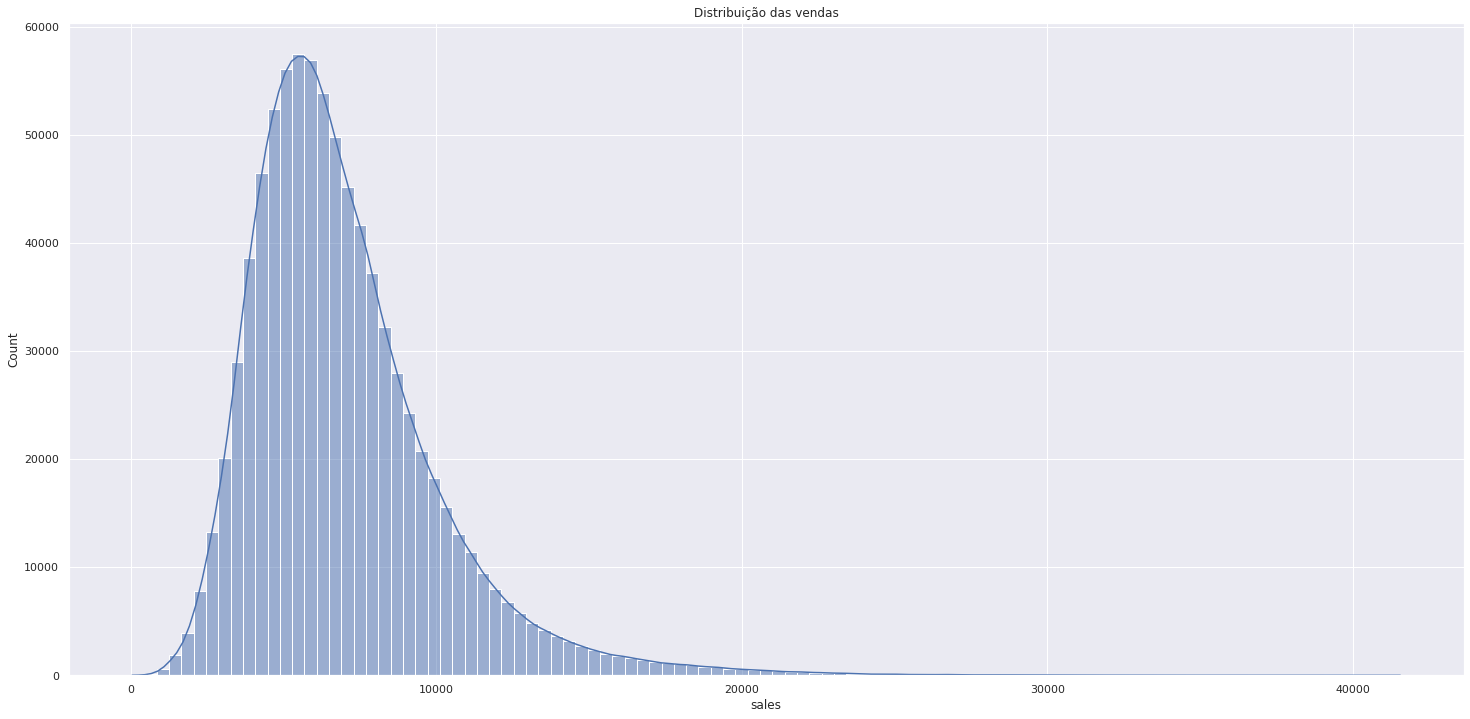

In [47]:
#@title Histograma: Sales
sns.histplot(df4.sales, kde=True, bins= int((df4.sales.max()-df4.sales.min())/400))
plt.title('Distribuição das vendas');

#### 4.1.2 Estatística Descritiva

###### 4.1.2.1 Atributos Numéricos:

In [48]:
#Central Tendency - mean, median

#Variáveis numéricas:
ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T #.T = transposto
ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersão - std,min,max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenando
m = pd.concat([d2,d3,d4,ct_mean,ct_median,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

m            

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.421374,558.0,321.730671,0.000426,-1.198836
1,day_of_week,1.0,7.0,6.0,3.520350,3.0,1.723711,0.019310,-1.259347
2,sales,46.0,41551.0,41505.0,6955.959134,6369.0,3103.813677,1.594929,4.854027
3,promo,0.0,1.0,1.0,0.446356,0.0,0.497114,0.215824,-1.953425
4,school_holiday,0.0,1.0,1.0,0.193578,0.0,0.395102,1.551109,0.405939
5,competition_distance,20.0,200000.0,199980.0,5961.827515,2330.0,12592.173650,10.134908,145.288658
6,competition_open_since_month,1.0,12.0,11.0,6.787355,7.0,3.309915,-0.048451,-1.231875
7,competition_open_since_year,1900.0,2015.0,115.0,2010.331102,2012.0,5.502625,-7.217323,123.903078
8,promo2,0.0,1.0,1.0,0.498670,0.0,0.499998,0.005320,-1.999976
9,promo2_since_week,1.0,52.0,51.0,23.629083,22.0,14.288306,0.170399,-1.194815


###### 4.1.2.2 Atributos Categóricos:

In [60]:
#Visualizando valores únicos
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
year_week        137
dtype: int64

In [61]:
df4['store_type'].drop_duplicates();

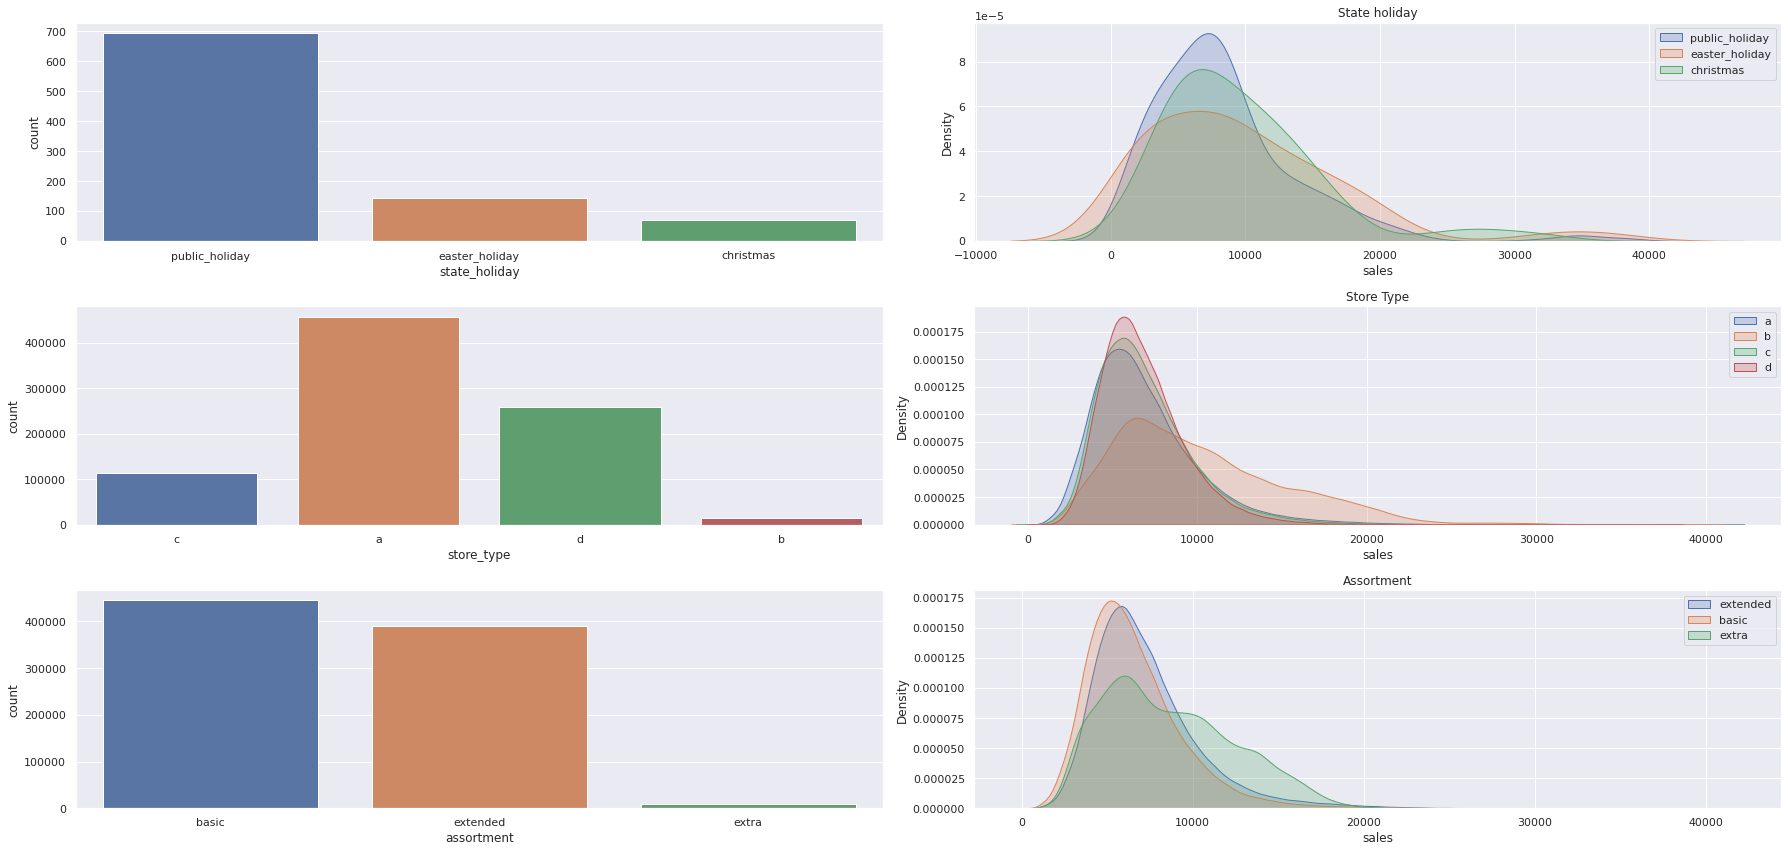

In [62]:
#@title Distribuição das variáveis categóricas (clique 2x para visualizar o código)

#state_holiday
plt.subplot(3,2,1);
a = df4[df4['state_holiday']!= 'regular_day'];
sns. countplot(x = a['state_holiday']);

plt.subplot(3,2,2);
sns.kdeplot(x = df4[df4['state_holiday']=='public_holiday'][
            'sales'], shade=True );
sns.kdeplot(x = df4[df4['state_holiday']=='easter_holiday'][
            'sales'], shade=True);
sns.kdeplot(x = df4[df4['state_holiday']=='christmas']['sales'], shade=True);
plt.legend( ('public_holiday','easter_holiday','christmas'),
           loc='upper right');
plt.title('State holiday');

#store_type
plt.subplot(3,2,3);
sns.countplot(x = df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(x = df4[df4['store_type']=='a']['sales'],shade=True );
sns.kdeplot(x = df4[df4['store_type']=='b']['sales'], shade=True);
sns.kdeplot(x = df4[df4['store_type']=='c']['sales'], shade=True);
sns.kdeplot(x = df4[df4['store_type']=='d']['sales'], shade=True);
plt.title('Store Type');
plt.legend( ('a','b','c','d'),  loc='upper right');

#assortment
plt.subplot(3,2,5);
sns.countplot(x = df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(x = df4[df4['assortment']=='extended']['sales'],shade=True );
sns.kdeplot(x = df4[df4['assortment']=='basic']['sales'], shade=True);
sns.kdeplot(x = df4[df4['assortment']=='extra']['sales'], shade=True);
plt.title('Assortment');
plt.legend( ('extended','basic','extra'),  loc='upper right');

plt.tight_layout();

## 4.2. Análise Bivariada

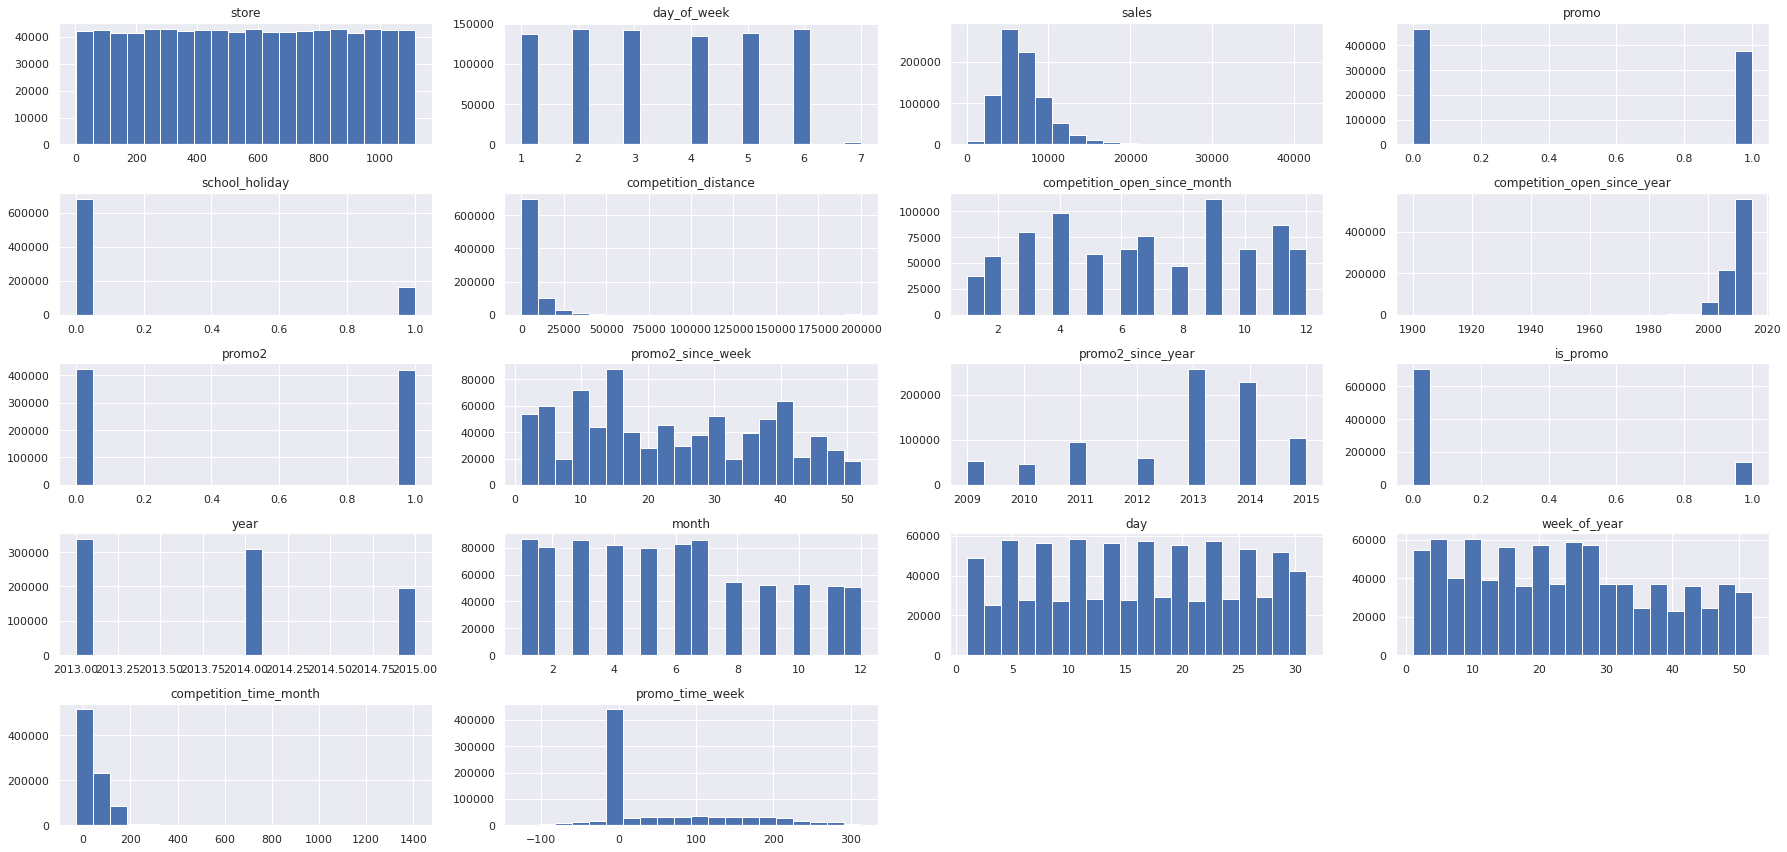

In [53]:
#@title 4.2.1 Variáveis numéricas x Vendas
num_attributes.hist(bins=20);
plt.tight_layout()

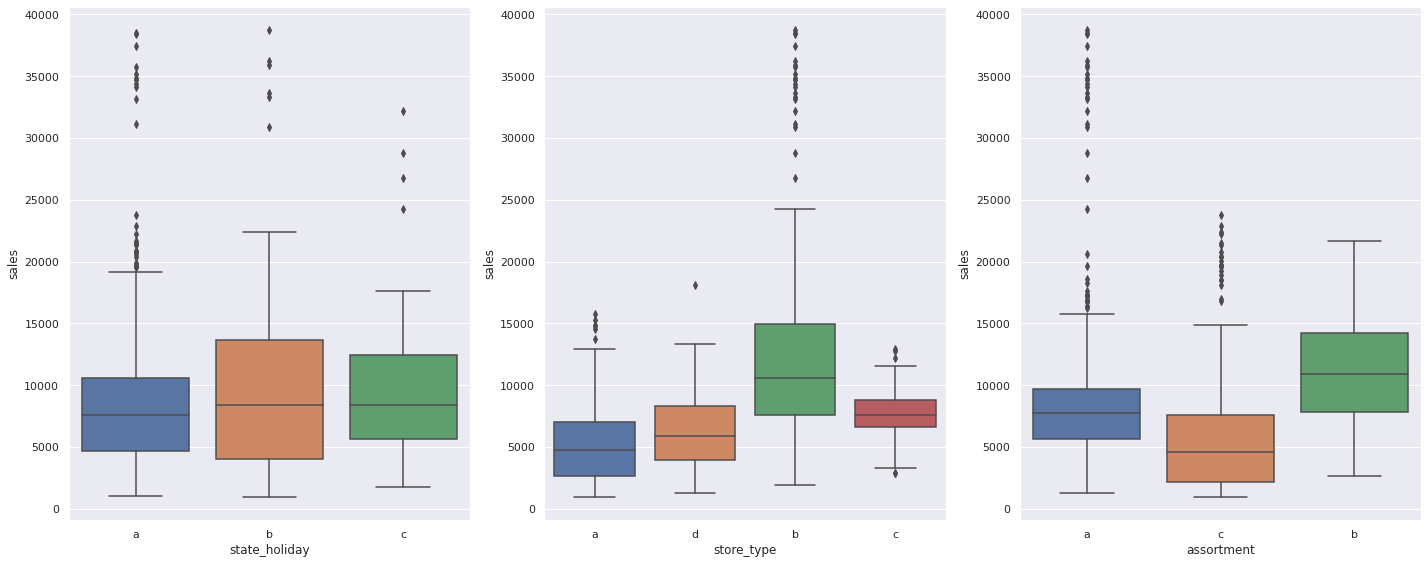

In [51]:
#@title 4.2.2 Variáveis Categóricas x Vendas
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]
plt.figure(figsize = (20,8))
plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data=aux1)
plt.tight_layout()

### 4.2.3 Validação de Hipóteses

#### H1. Lojas com maior sortimento deveriam vender mais.



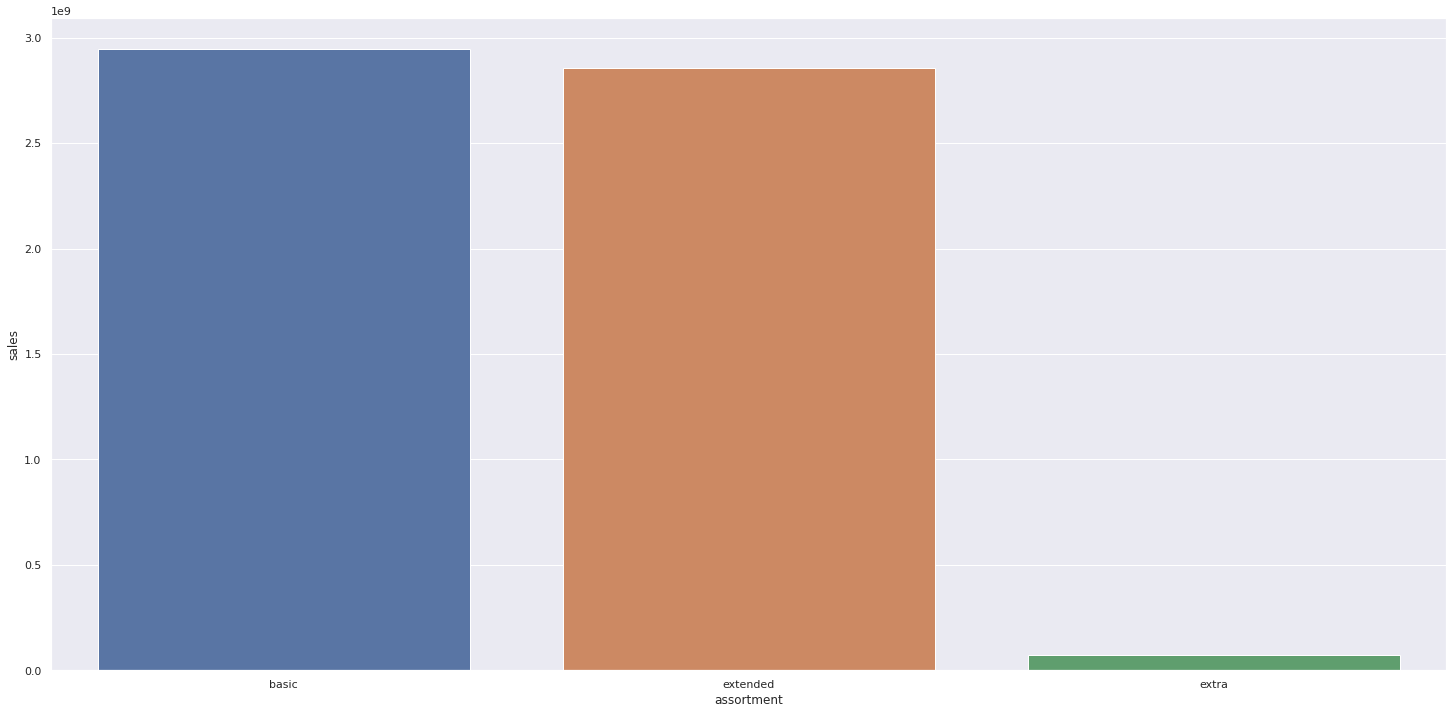

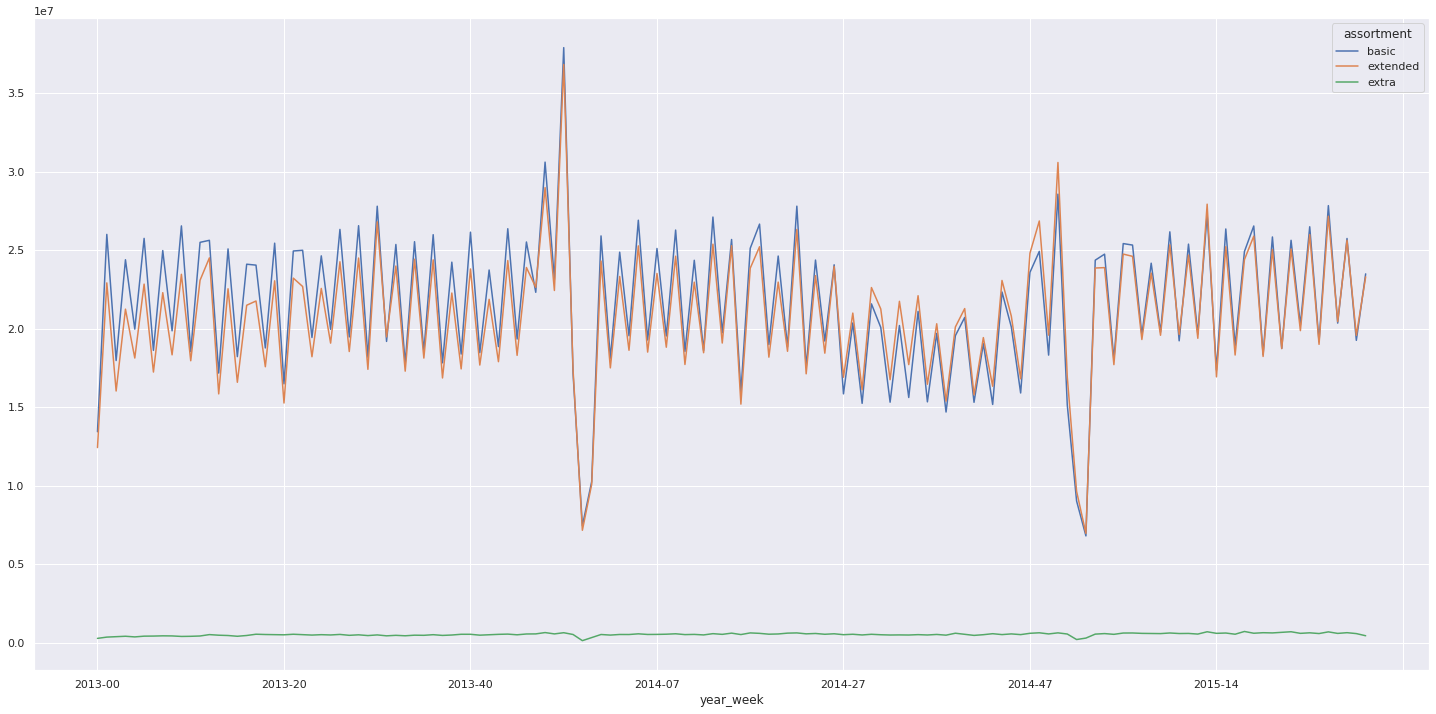

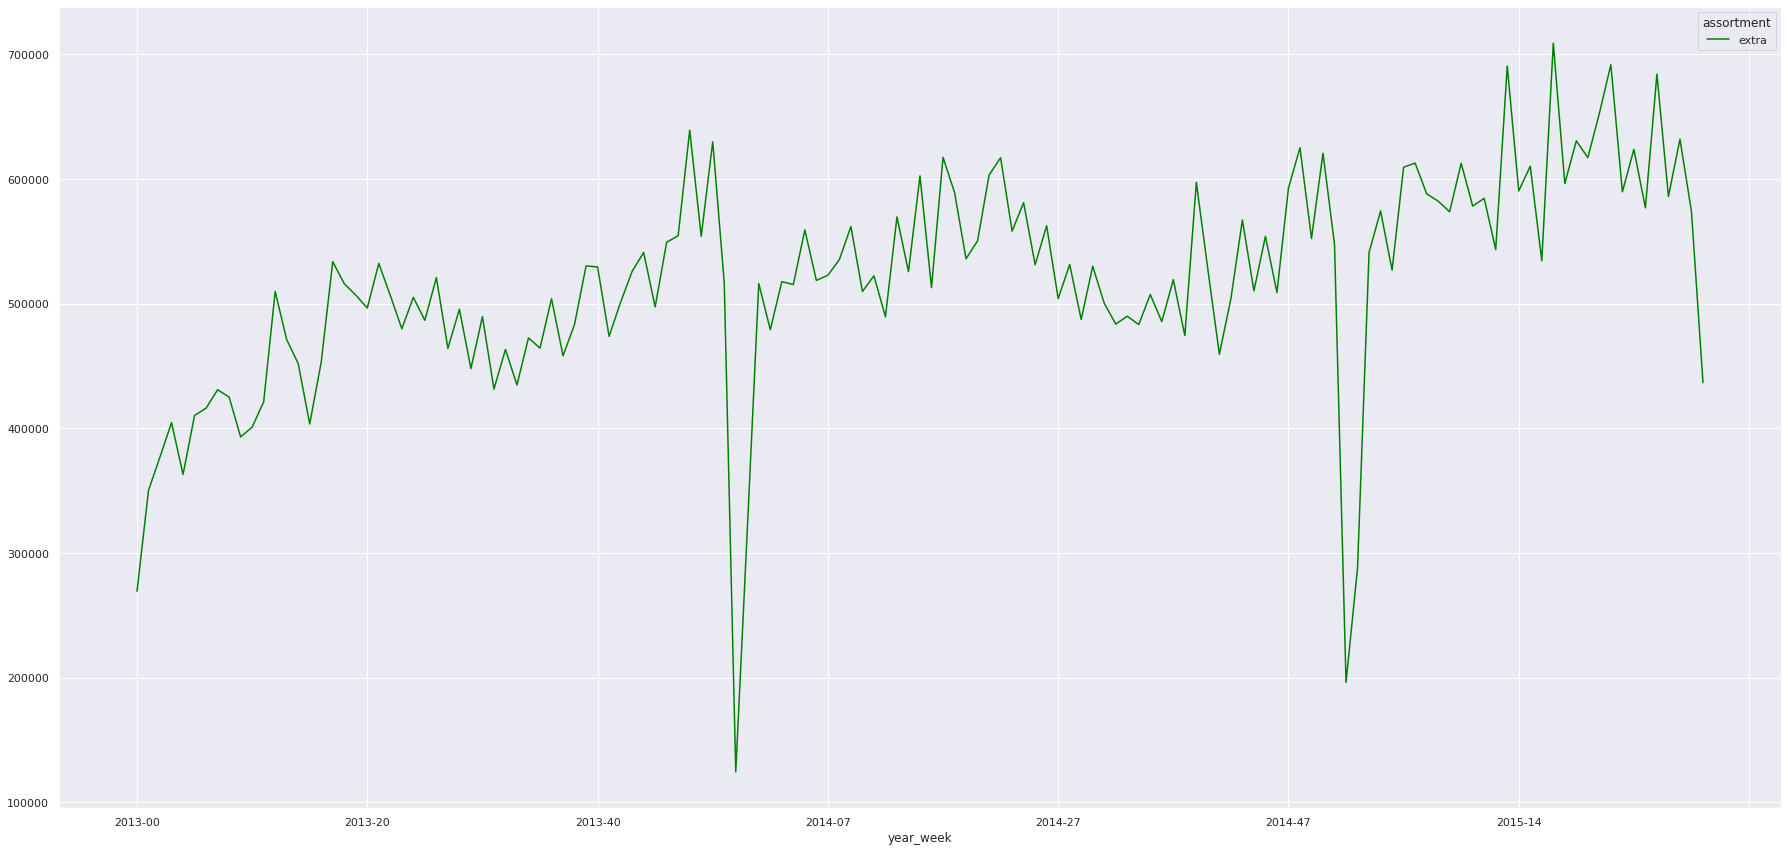

In [64]:
#@title **Falsa!** Na verdade, lojas com maior sortimento vendem menos
aux1 = df4[['assortment', 'sales']].groupby(
      'assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales', data=aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(
      ['year_week','assortment']).sum().reset_index()

aux2.pivot(index='year_week', columns='assortment',
           values='sales').plot()      

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment',
           values='sales').plot(color = 'green')      

plt.tight_layout()

#### H2. Lojas com competidores mais próximos deveriam vender menos.

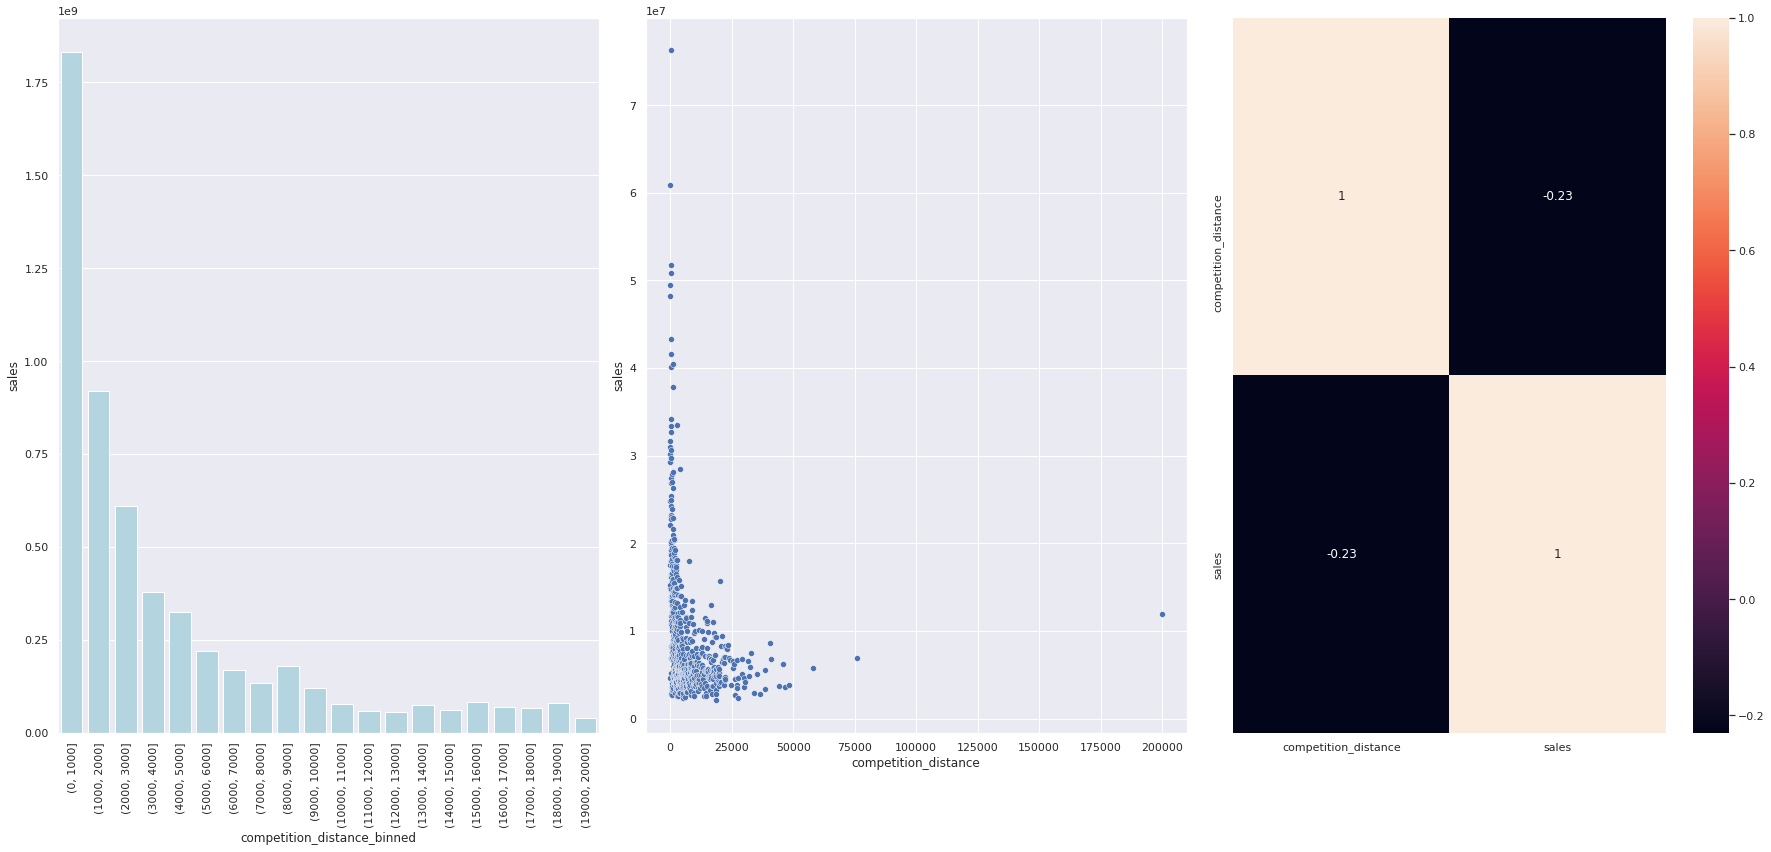

In [65]:
#@title Falsa! Lojas com competidores mais próximos vendem mais.
aux1 = df4[['competition_distance', 'sales']].groupby(
    'competition_distance',).sum().reset_index()

bins = list(range(0,21000,1000))

aux1['competition_distance_binned'] = pd.cut(
      aux1['competition_distance'], bins=bins) 


aux2 =  aux1[['competition_distance_binned', 'sales']].groupby(
    'competition_distance_binned',).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'competition_distance_binned', y='sales',
            data = aux2, color='lightblue') 
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.scatterplot(x = 'competition_distance', y='sales', data = aux1 )

#medindo a correlação
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)
plt.tight_layout()



#### H3. Lojas com competidores a mais tempo deveriam vender mais.

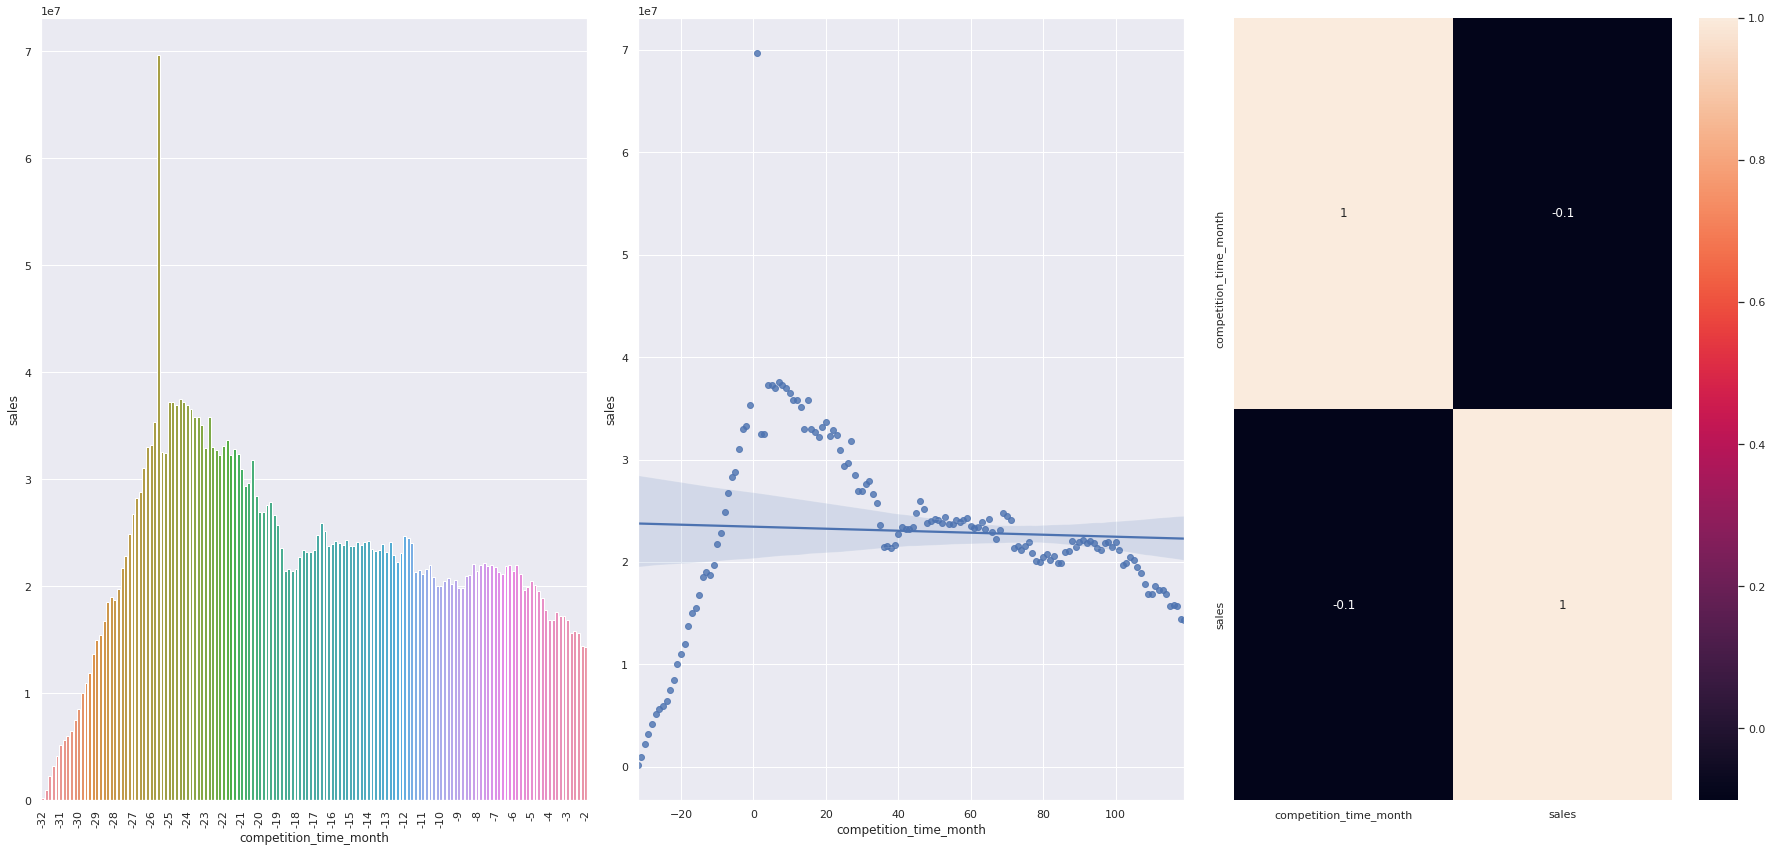

In [101]:
#@title **Falsa!** Lojas com competidores a mais tempo vendem menos!

aux1 = df4[['competition_time_month', 'sales']].groupby(
    'competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <120) & (
    aux1['competition_time_month'] !=0 )]


plt.subplot(1,3,1)
sns.barplot(x= 'competition_time_month',y='sales',data = aux2 );
plt.xticks(np.arange(0,155,5),rotation=90);

plt.subplot(1,3,2)
sns.regplot(x= 'competition_time_month',y='sales',data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)
plt.tight_layout()

#### H4. Lojas com promoções ativas por mais tempo nos produtos deveriam vender mais.

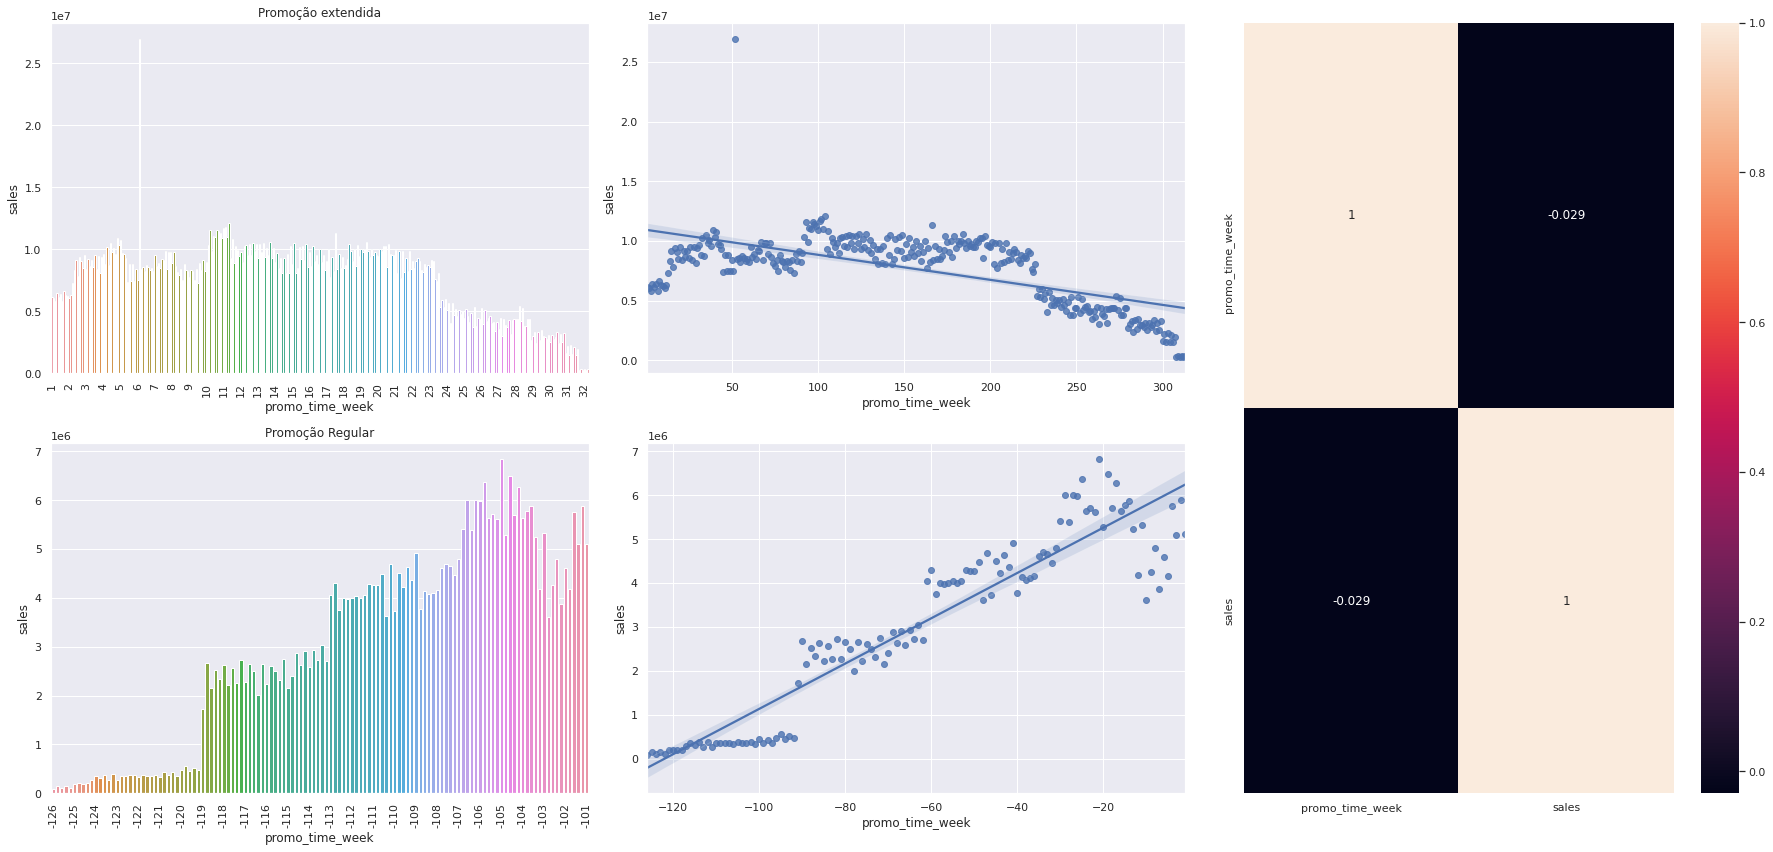

In [115]:
#@title **Falsa!** As vendas decaem após certo período de promoção. 

aux1=df4[['promo_time_week', 'sales']].groupby(
    'promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] #promoção extendida
sns.barplot(x='promo_time_week', y='sales',data=aux2);
plt.xticks(np.arange(0,320,10),rotation=90)
plt.title("Promoção extendida")

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales',data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] #promoção regular
sns.barplot(x='promo_time_week', y='sales',data=aux3);
plt.xticks(np.arange(0,130,5),rotation=90)
plt.title("Promoção Regular")

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales',data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

plt.tight_layout()

#### H5. Lojas com mais promoções consecutivas deveriam vender mais.

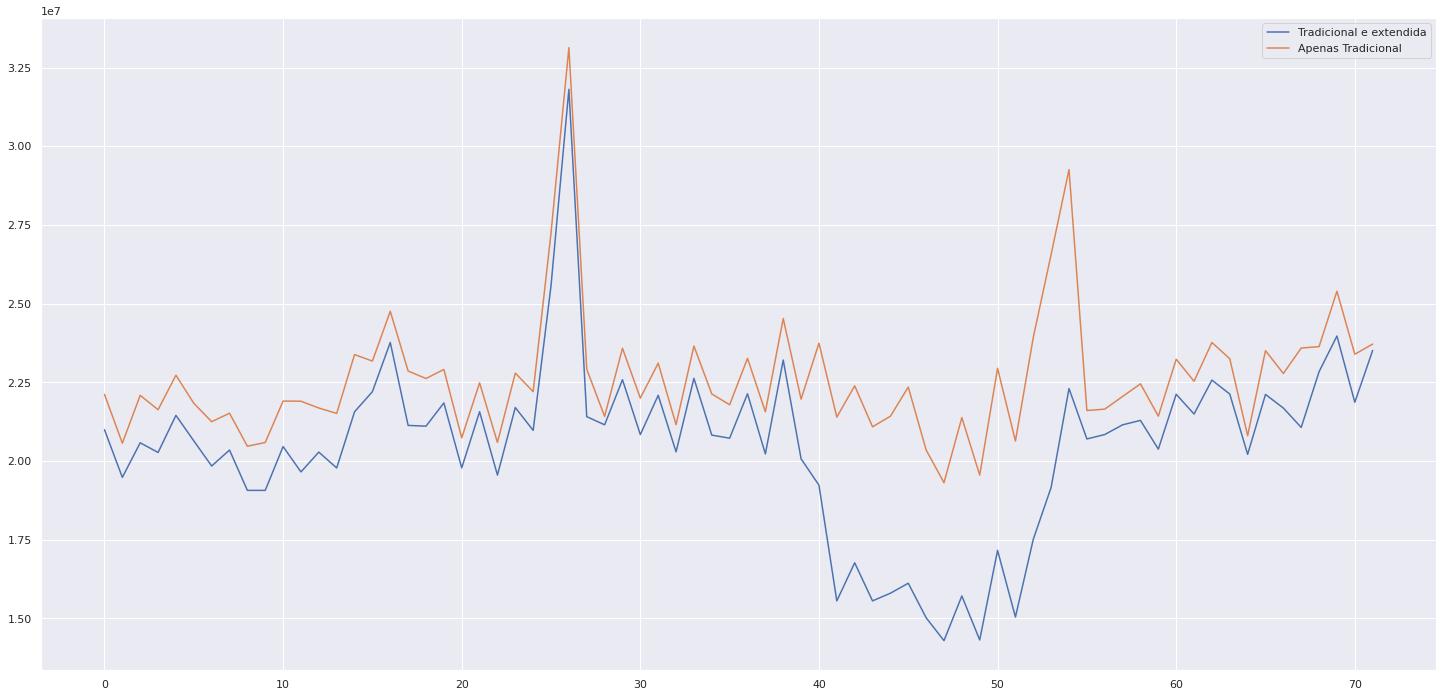

In [126]:
#@title **Falsa!**, lojas que participaram apenas da promo1 venderam mais.
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum(
    ).reset_index().sort_values(by='sales')

#Vendo o comportamento ao longo do tempo
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']
          ].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']
          ].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels = ['Tradicional e extendida', 'Apenas Tradicional']);

#### H6. Lojas abertas durante o Natal deveriam vender mais.


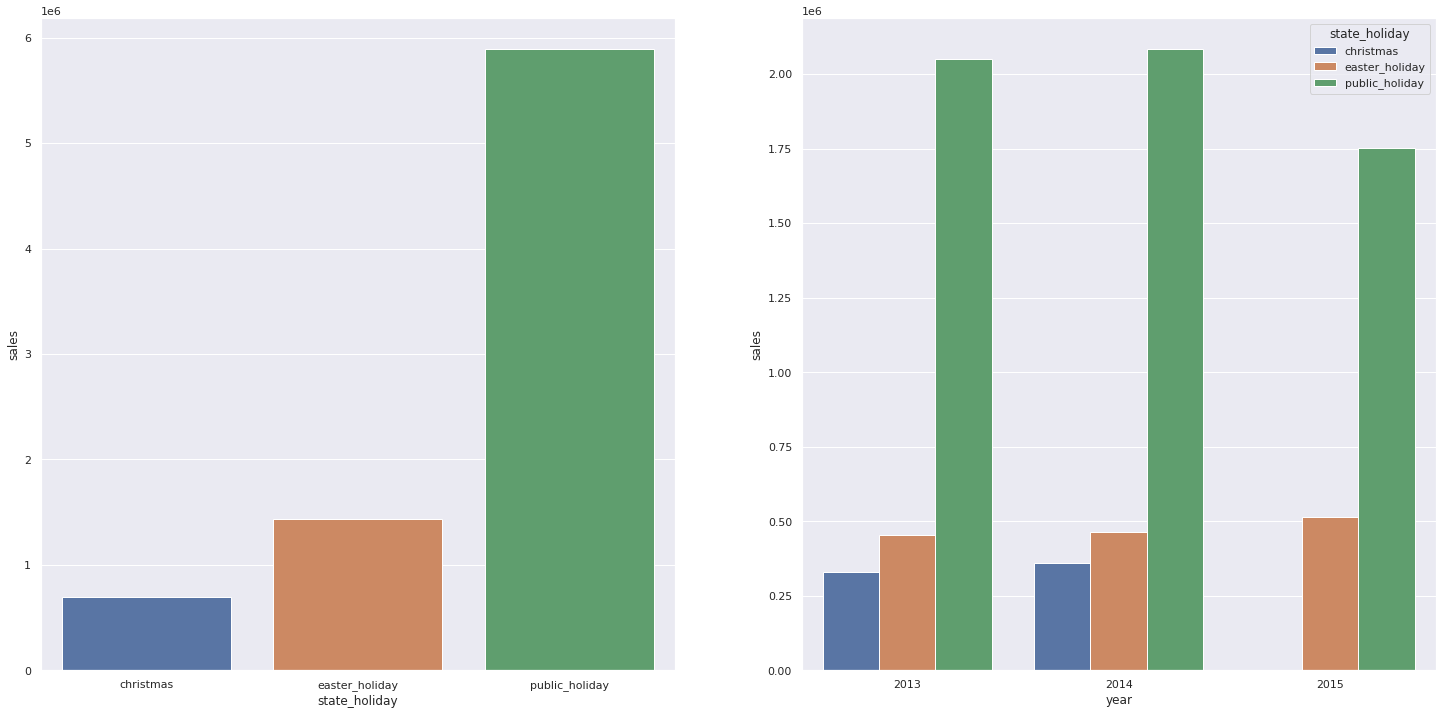

In [128]:
#@title **Falsa!** Lojas vendem menos durante o natal
aux = df4[df4['state_holiday']!='regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum(
        ).reset_index()

plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales',data=aux1);
plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(
    ['year','state_holiday']).sum().reset_index()
    
sns.barplot(x='year',y='sales',data=aux2, hue='state_holiday' );

#### H7. Lojas deveriam vender mais ao longo dos anos.

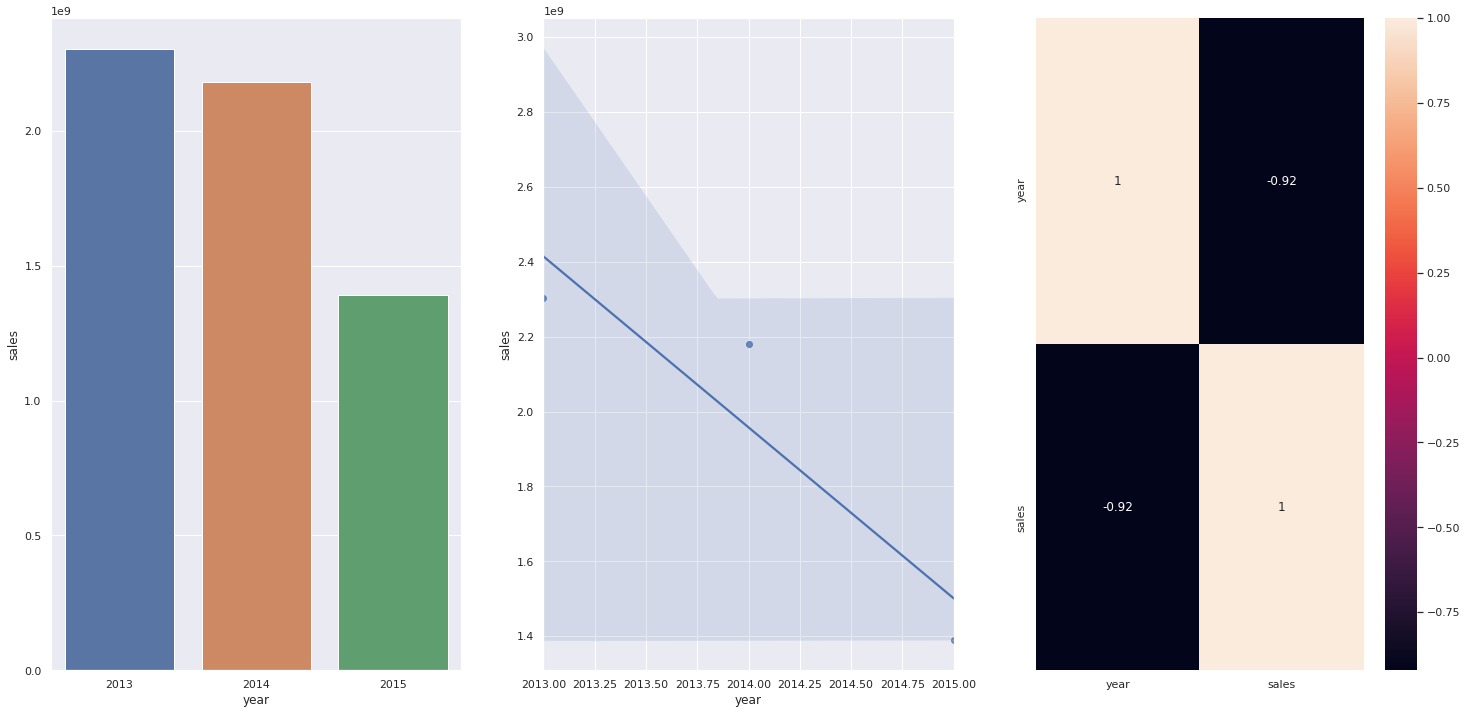

In [118]:
#@title **Falsa!** As vendas estão caindo.
#obs: 2015 não está completo!
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H8. Lojas deveriam vender mais no segundo semestre do ano.

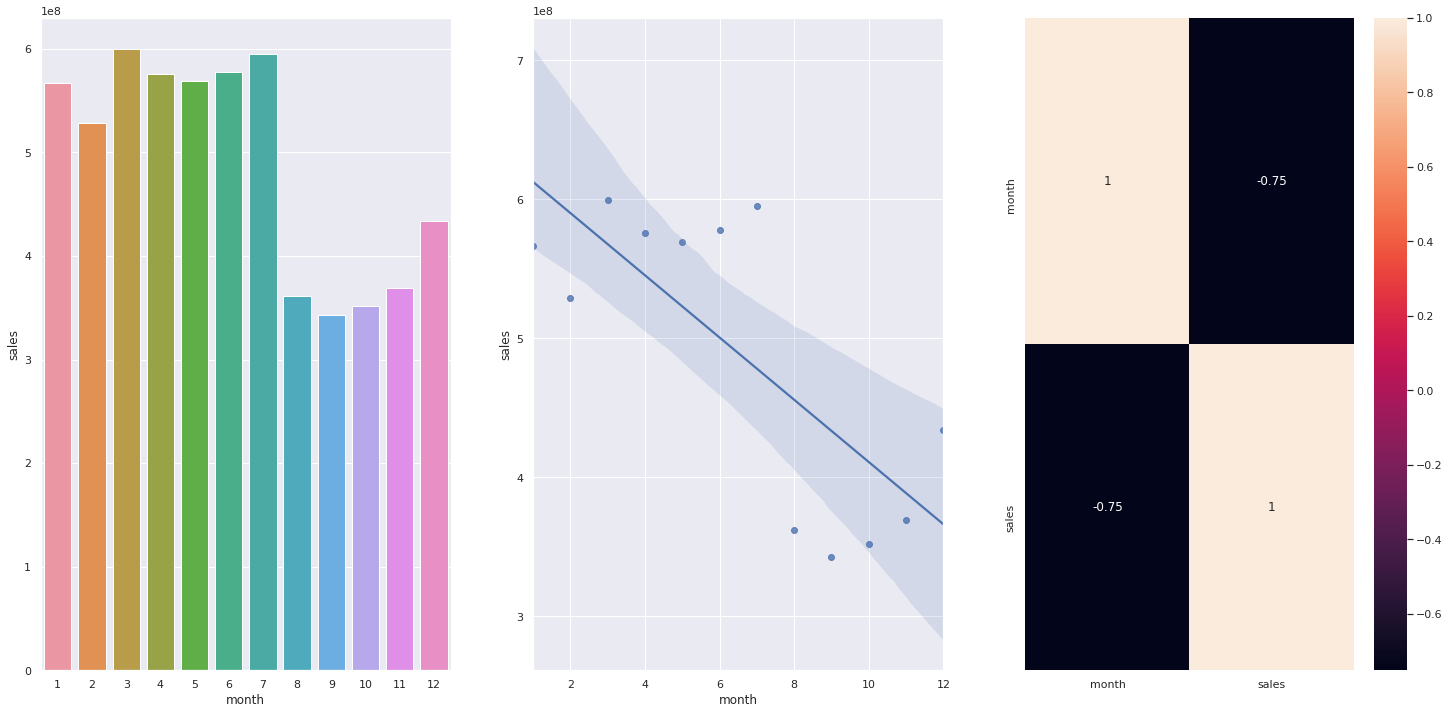

In [ ]:
#@title **Falsa!** Lojas vendem menos no segundo semestre.
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H9. Lojas deveriam vender mais depois do dia 10 de cada mês.

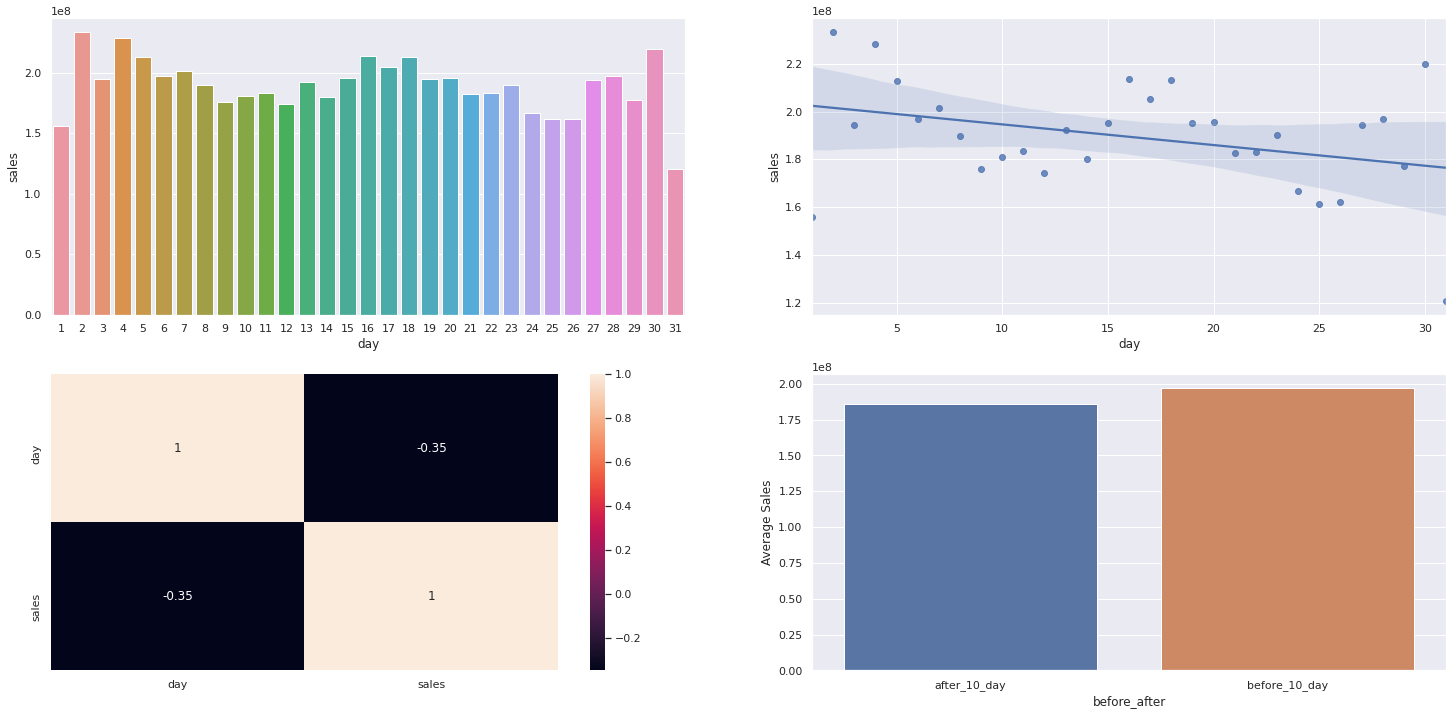

In [129]:
#@title **Falso**. A média de vendas é pouco maior nos 10 primeiros dias do mês
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after']=aux1['day'].apply(lambda x: 
                          'before_10_day' if x<=10 else 'after_10_day')

aux2 = aux1[['before_after','sales']].groupby(
                          'before_after').mean().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);
plt.ylabel("Average Sales");

#### H10. Lojas deveriam vender menos aos finais de semana.

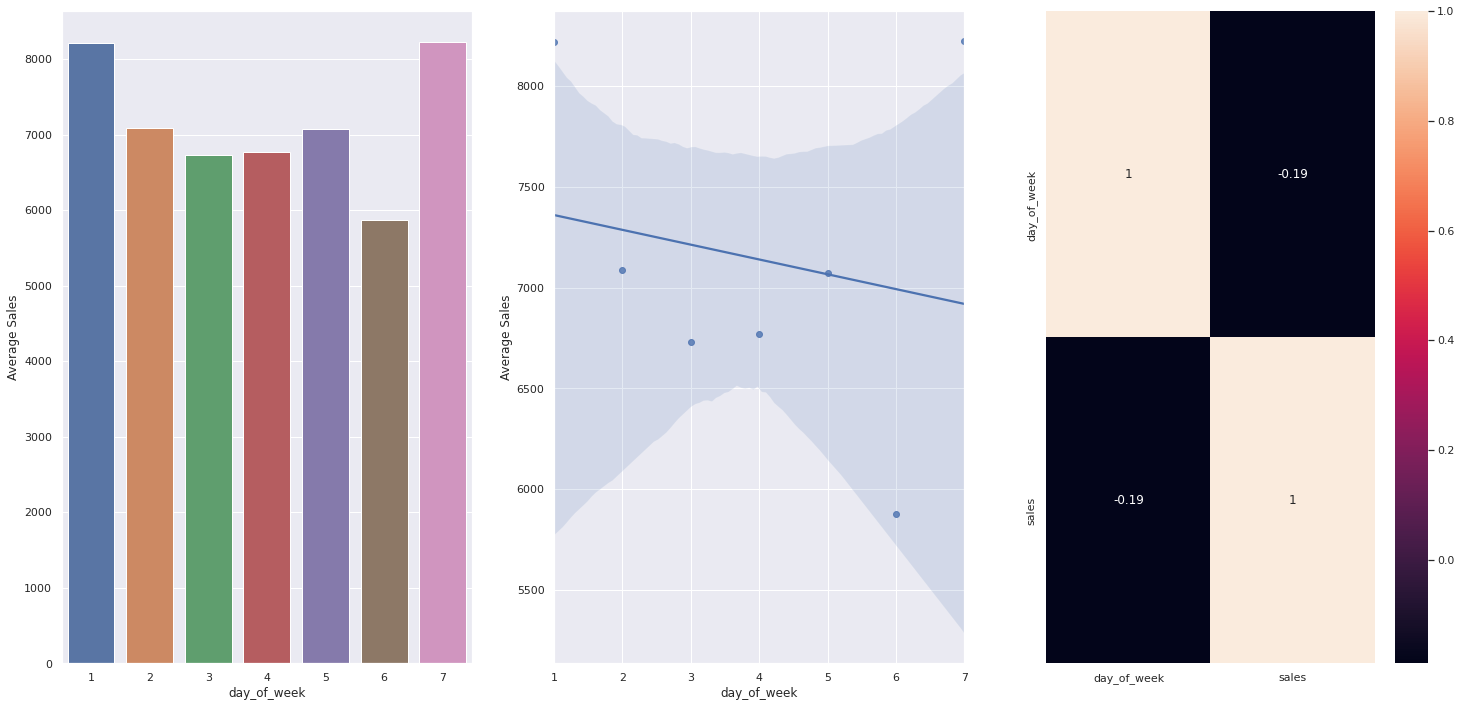

In [134]:
#@title **Parcialmente Verdadeiro!** A média de vendas é menor aos sábados, mas maior aos Domingos.
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').mean(
                                  ).reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);
plt.ylabel("Average Sales")

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);
plt.ylabel("Average Sales")

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H11. Lojas deveriam vender menos durante os feriados escolares.

Text(0, 0.5, 'Average Sales')

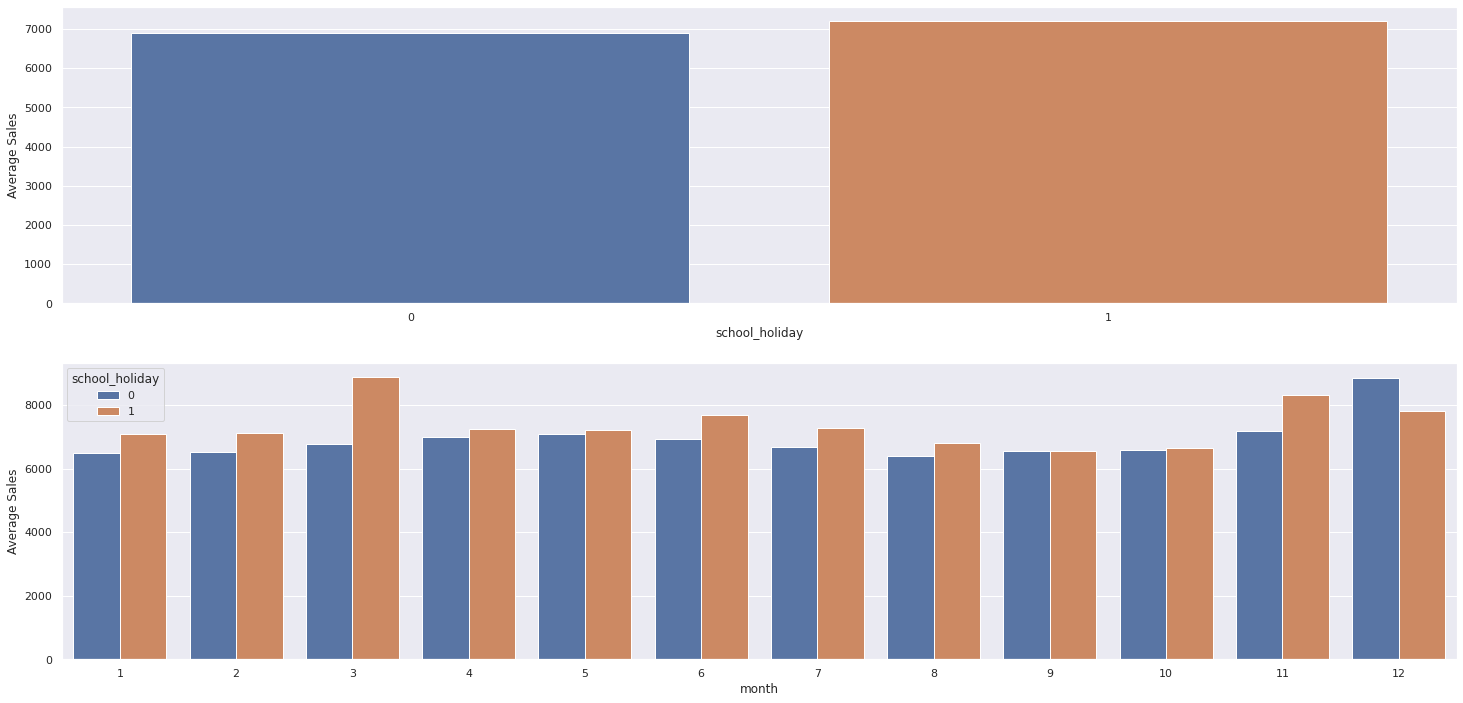

In [137]:
#@title **Falso!** Em média, as lojas vendem mais nos feriados escolares.
aux = df4[['school_holiday','sales']].groupby(
           'school_holiday').mean().reset_index()


plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales',data=aux);

aux1 = df4[['month','school_holiday','sales']].groupby(
           ['month','school_holiday']).mean().reset_index()
plt.ylabel("Average Sales")

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales',hue = 'school_holiday',data=aux1);
plt.ylabel("Average Sales")

#### 4.2.4.1 Resumo das Hipóteses

In [139]:
#@title Tabela resumo
tab = [['Hipóteses','Conclusão','Relevância'],
       ['H1','Falsa','Baixa'],
       ['H2','Falsa','Média'],
       ['H3','Falsa','Média'],
       ['H4','Falsa','Baixa'],
       ['H5','Falsa','Baixa'],
       ['H6','Falsa','Média'],
       ['H7','Falsa','Alta'],
       ['H8','Falsa','Alta'],
       ['H9','Falsa','Alta'],
       ['H10','Parc. Verdade','Alta'],
       ['H11','Falsa','Baixa'],
       ]
print(tabulate(tab,headers='firstrow'))

Hipóteses    Conclusão      Relevância
-----------  -------------  ------------
H1           Falsa          Baixa
H2           Falsa          Média
H3           Falsa          Média
H4           Falsa          Baixa
H5           Falsa          Baixa
H6           Falsa          Média
H7           Falsa          Alta
H8           Falsa          Alta
H9           Falsa          Alta
H10          Parc. Verdade  Alta
H11          Falsa          Baixa


## 4.3. Análise Multivariada

#### 4.3.1 Atributos Numéricos

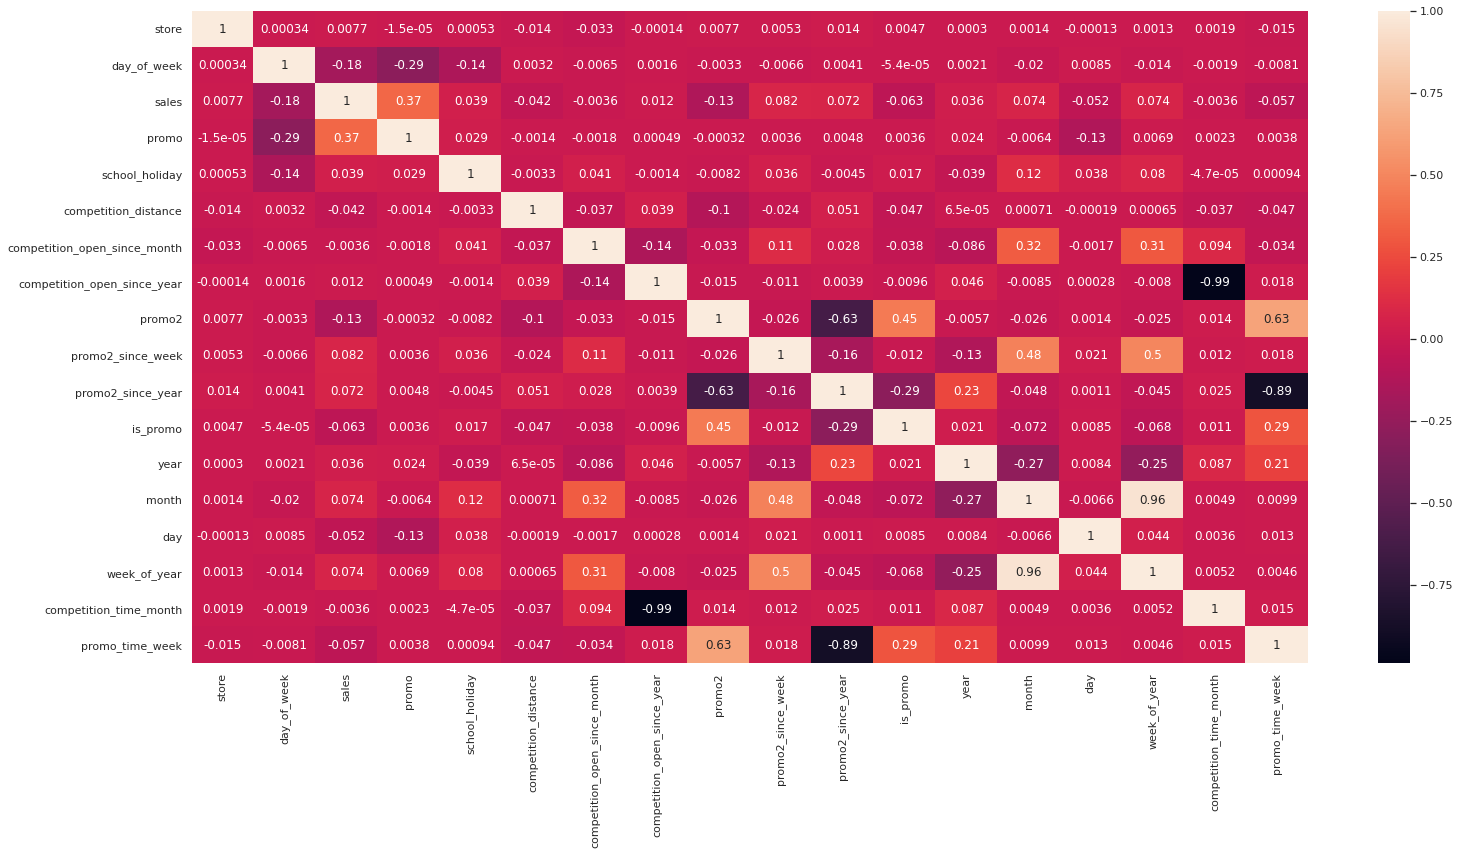

In [143]:
correlation = num_attributes.corr(method ='pearson')
sns.heatmap(correlation,annot=True);

#### 4.3.2 Atributos Categóricos

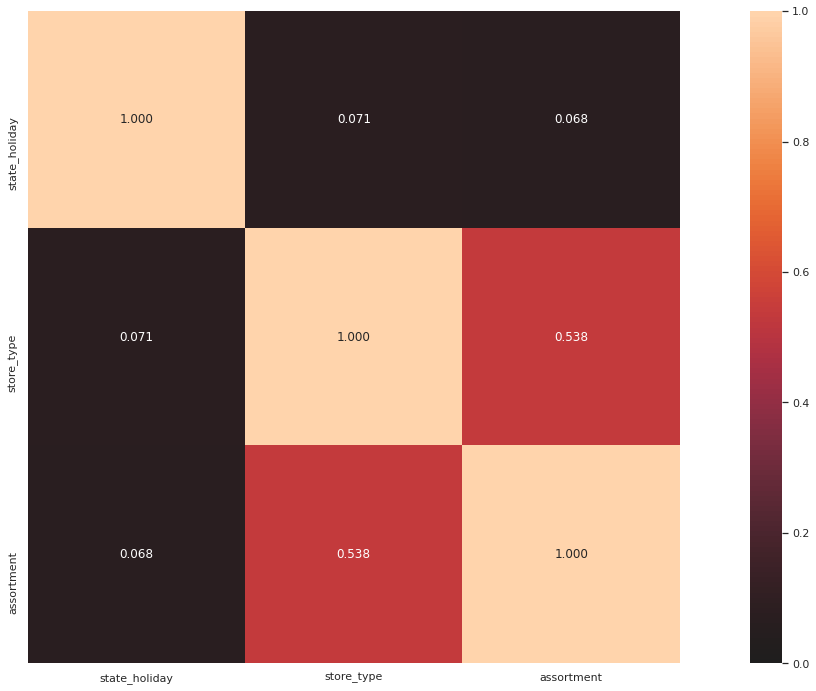

In [144]:
aux = cat_attributes.drop(columns = 'year_week')
associations(aux,fmt='.3f');

In [142]:
#@title Deve-se utilizar a correlação Cramer-V, a qual a fórmula é:
Image('Imagens/cramer_v.png')

---
# 5.0 PREPARAÇÃO DOS DADOS

In [197]:
df5 = df4.copy()

### 5.1 Split entre treino e teste 

In [198]:
#Qual a data em que inicia as 6 semanas finais?
df5[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)
# Resposta: 2015-06-19 

Timestamp('2015-06-19 00:00:00')

In [199]:
#dataset de treino
df_treino = df5[df5['date']< '2015-06-19']

#dateset de test
df_teste = df5[df5['date'] >= '2015-06-19']

print('Data mínima de treino: {}'.format(X_train['date'].min()))
print('Data Máxima de treino: {}'.format(X_train['date'].max()))

print('Data mínima de teste: {}'.format(X_test['date'].min()))
print('Data máxima de teste: {}'.format(X_test['date'].max()))

Data mínima de treino: 2013-01-01 00:00:00
Data Máxima de treino: 2015-06-18 00:00:00
Data mínima de teste: 2015-06-19 00:00:00
Data máxima de teste: 2015-07-31 00:00:00


### 5.2 Normalização

In [177]:
#Nenhuma coluna tem distribuição semelhante à normal
#Interessante utilizar o sklearn.normalizer 

### 5.3 Rescaling

In [200]:
# - MinMax scaler para distribuições sem muitos outliers
# - Robust scaler para distribuições com muitos outliers
num = df_treino.select_dtypes(include=['int64','float64','int32','float32'])

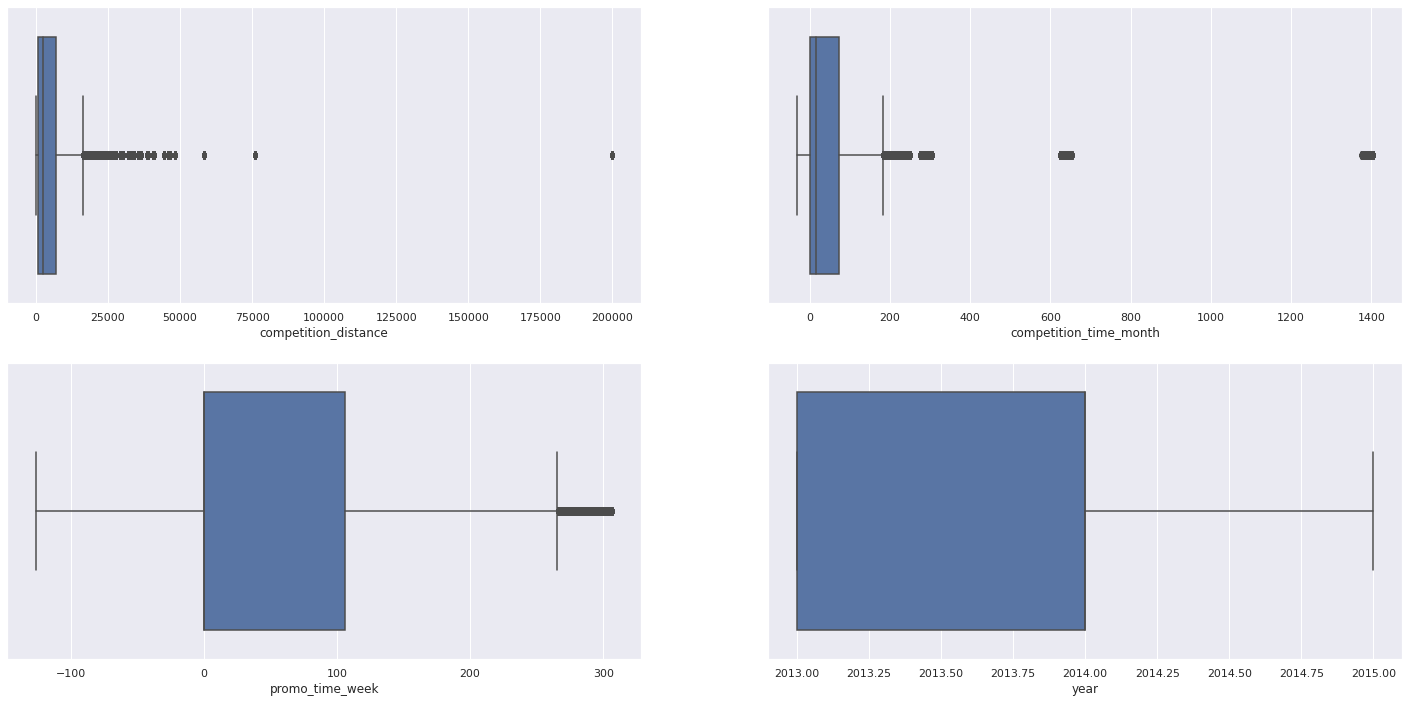

In [201]:
plt.subplot(2,2,1)
sns.boxplot(x = df_treino['competition_distance']); #muitos outliers, usar RobustScaler

plt.subplot(2,2,2)
sns.boxplot(x = df_treino['competition_time_month']); #muitos outliers, usar RobustScaler

plt.subplot(2,2,3) 
sns.boxplot(x = df_treino['promo_time_week']); #poucos outliers, usar MinMaxScaler

plt.subplot(2,2,4) 
sns.boxplot(x= df_treino['year']); #poucos outliers, usar MinMaxScaler

In [ ]:
#Fazendo o Rescaling:

rs = RobustScaler()
mm = MinMaxScaler()

#competition distance
df_treino['competition_distance'] = rs.fit_transform(df_treino[['competition_distance']].values);

#Fazendo o dump da transformação no pickle (para posteriormente colocar o modelo em produção):
pickle.dump(rs, open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/competition_distance_scaler.pkl', 'wb'))

#competition time month
df_treino['competition_time_month'] = rs.fit_transform(df_treino[['competition_time_month']].values);
pickle.dump(rs, open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/competition_time_month_scaler.pkl', 'wb'))

#promo time week
df_treino['promo_time_week'] = mm.fit_transform(df_treino[['promo_time_week']].values);
pickle.dump(mm, open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/promo_time_week_scaler.pkl', 'wb'))

#year
df_treino['year'] = mm.fit_transform(df_treino[['year']].values);
pickle.dump(mm, open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/year_scaler.pkl', 'wb'))

### 5.4 Transformação

#### 5.4.1 Transformação de grandeza da variável de resposta

In [ ]:
#Transformação logarítmica
df_treino['sales'] = np.log1p(df_treino['sales'])

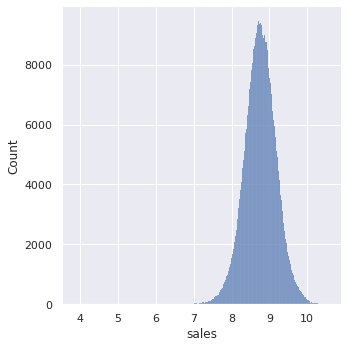

In [210]:
sns.displot(df_treino['sales']);

#### 5.4.2 Transformação de natureza das variáveis temporais

In [ ]:
#day of week
df_treino['day_of_week_sin'] = df_treino['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df_treino['day_of_week_cos'] = df_treino['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

#month - transformação cíclica
df_treino['month_sin'] = df_treino['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df_treino['month_cos'] = df_treino['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

#day
df_treino['day_sin'] = df_treino['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df_treino['day_cos'] = df_treino['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

#week of year
df_treino['week_of_year_sin'] = df_treino['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df_treino['week_of_year_cos'] = df_treino['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

In [212]:
df_treino.sample()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
979091,907,1,2013-02-04,8.668024,1,regular_day,0,a,extended,-0.335484,2,2013,0,6,2013,0,0.0,2,4,6,2013-05,2013-02-01,-0.219178,2013-02-04,0.290993,0.781831,0.62349,0.866025,0.5,0.743145,0.669131,0.663123,0.748511


#### 5.4.3 Encoding

In [213]:
#state_holiday: one-hot encoding
df_treino = pd.get_dummies(df_treino, prefix = ['state_holiday'], columns = ['state_holiday'])

In [214]:
#store_type: label encoding
lb=LabelEncoder()
df_treino['store_type']=lb.fit_transform(df_treino['store_type'])

#Pickle: 
pickle.dump(lb, open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/store_type_scaler.pkl', 'wb'))

In [215]:
#assortment: ordinal encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3
                   }
df_treino['assortment'] = df_treino['assortment'].map(assortment_dict)

In [216]:
df_treino.head(3)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
47945,1,4,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,6,18,25,2015-24,2008-09-01,0.904110,2015-06-15,0.290993,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,0,0,0,1
47946,2,4,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,6,18,25,2015-24,2007-11-01,1.041096,2010-03-22,0.921478,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,0,0,0,1
47947,3,4,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,6,18,25,2015-24,2006-12-01,1.205479,2011-03-28,0.799076,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,0,0,0,1


---
# 6.0 FEATURE SELECTION

In [217]:
#Dropar variáveis que foram transformadas
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since', 'year_week']
df_treino = df_treino.drop(cols_drop, axis=1)

### 6.1 Selecionando as melhores Features com o Algoritmo Boruta

In [191]:


# X_train_bor = X_train.drop(columns=['date']).values
# y_train_bor = y_train.values.ravel() #ravel coloca em um vetor

# define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

#define boruta:
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=1).fit(X_train_bor, y_train_bor)


### 6.2 Obtendo as Melhores Features:

In [192]:

#cols_selected = boruta.support_.tolist()

#best features
#X_train_bf = X_train.drop(columns=['date'])
#cols_selected_boruta = X_train_bf.iloc[:,cols_selected].columns.to_list()

#not selected
#cols_not_selected_boruta = list(np.setdiff1d(X_train_bf.columns, cols_selected_boruta))


### 6.3 Colunas Obtidas

In [193]:
cols_not_selected_boruta= ['is_promo',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'year'] 


In [220]:
cols_selected_boruta = ['assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_time_month',
 'day_sin',
 'day_cos',
 'day_of_week_cos',
 'day_of_week_sin',
 'month_sin',
 'month_cos',
 'promo',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'store',
 'store_type',
 'week_of_year_sin',
 'week_of_year_cos']

 #colunas para adicionar: 
feat_to_add = ['date', 'sales']

In [221]:
#Features Finais
cols_selected_boruta_full = cols_selected_boruta.copy()

cols_selected_boruta_full.extend(feat_to_add)
cols_selected_boruta_full

['assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_time_month',
 'day_sin',
 'day_cos',
 'day_of_week_cos',
 'day_of_week_sin',
 'month_sin',
 'month_cos',
 'promo',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'store',
 'store_type',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

---
# 6.0 MACHINE LEARNING MODELLING

In [227]:
#Dataset para o cross validation: 
df_treino_ml = df_treino[cols_selected_boruta_full]

### 6.1 Modelo de regressão linear: servirá como baseline

In [228]:
y_train = df_treino_ml['sales'] 
X_train = df_treino_ml.drop(columns=['sales','date'])

In [230]:
#Model
lr = LinearRegression().fit(X_train,y_train)

#performance
lr_cv = TimeSeries_cross_validation(df_treino_ml, 5, 'Linear Regression', lr )
lr_cv


Kfold_number: 5
MAE = 2646.810011610862
MAPE = 0.31137308327122476
RMSE = 3821.9010057952128

Kfold_number: 4
MAE = 1908.4710905165302
MAPE = 0.32825251975790787
RMSE = 2576.457764050245

Kfold_number: 3
MAE = 1803.9807231985062
MAPE = 0.3040775751546986
RMSE = 2522.9104554950136

Kfold_number: 2
MAE = 2069.335137766159
MAPE = 0.28553250427267596
RMSE = 3001.3342903704197

Kfold_number: 1
MAE = 1980.0391511732432
MAPE = 0.28389281001393885
RMSE = 2840.000319428244


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 6.3 Linear Regression Regularized Model - LASSO

In [232]:
#Model
lasso = Lasso(alpha = 0.01).fit(X_train,y_train)

#performance - cross validation
lasso_cv = TimeSeries_cross_validation(df_treino_ml, 5, 'Lasso - CV', lasso)
lasso_cv #Um pouco pior que a RL comum, o modelo é complexo.


Kfold_number: 5
MAE = 2751.45772969123
MAPE = 0.31444700745755
RMSE = 3976.1698822309354

Kfold_number: 4
MAE = 1846.85134014721
MAPE = 0.2911393742797097
RMSE = 2630.90187654536

Kfold_number: 3
MAE = 1808.434156395209
MAPE = 0.28909616304965313
RMSE = 2594.857897302576

Kfold_number: 2
MAE = 2160.6463422004686
MAPE = 0.2846318024391607
RMSE = 3168.024644041631

Kfold_number: 1
MAE = 2014.533600312529
MAPE = 0.2807205269505963
RMSE = 2918.81744864363


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso - CV,2116.38 +/- 341.51,0.29 +/- 0.01,3057.75 +/- 504.27


### 6.4 Random Forest Regressor

In [234]:
#Modelo
rf = RandomForestRegressor(n_estimators=100, random_state=1).fit(X_train,y_train)

#Avaliação - Cross-Validation
rf_cv = TimeSeries_cross_validation(df_treino_ml, 5, 'RandomForest - CV', rf)
rf_cv


Kfold_number: 5
MAE = 1192.863605614469
MAPE = 0.14815187913217845
RMSE = 1772.6931262729095

Kfold_number: 4
MAE = 879.6664683866827
MAPE = 0.13570868881229414
RMSE = 1323.2230629544913

Kfold_number: 3
MAE = 551.3410339962226
MAPE = 0.08834653698965814
RMSE = 858.757874395104

Kfold_number: 2
MAE = 858.5942971881386
MAPE = 0.10969029305641695
RMSE = 1313.2169809800885

Kfold_number: 1
MAE = 696.5958133024109
MAPE = 0.09727999033921178
RMSE = 1004.350411655701


,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForest - CV,835.81 +/- 214.58,0.12 +/- 0.02,1254.45 +/- 314.92


### 6.5 XGBoost Regressor

In [236]:

#Model
xgb = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=100, eta = 0.01, max_depth = 10,
                       subsample=0.7, colsample_bytree=0.9, n_jobs=-1, random_state=1).fit(X_train,y_train)

#Avaliação - Cross-Validation
xgb_cv = TimeSeries_cross_validation(df_treino_ml, 5, 'XGBoost - CV', xgb)
xgb_cv


Kfold_number: 5
MAE = 1320.3670279858022
MAPE = 0.16924176598517016
RMSE = 1875.3251065945099

Kfold_number: 4
MAE = 957.4444296655315
MAPE = 0.14172072727746596
RMSE = 1375.2795047829948

Kfold_number: 3
MAE = 846.7435658443877
MAPE = 0.1295370885929852
RMSE = 1237.6192059181394

Kfold_number: 2
MAE = 1094.8557780716742
MAPE = 0.13992749525522294
RMSE = 1639.3139926455888

Kfold_number: 1
MAE = 970.2617693532158
MAPE = 0.13087660759198644
RMSE = 1386.3769230381583


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost - CV,1037.93 +/- 161.63,0.14 +/- 0.01,1502.78 +/- 226.96


#### 6.5.1 XGBoost Cross Validation

In [ ]:
'''

'''

"\nxgb_cv = TimeSeries_cross_validation(x_training, 5, 'XGBoost - CV', xgb)\nxgb_cv\n"

### 6.6 Comparação das performances dos modelos

In [ ]:
#modelling_result = pd.concat([lr_cv, lasso_cv, rf_cv, xgb_cv])
#modelling_result.sort_values('RMSE CV') 

In [ ]:

modelling_result = pd.DataFrame(data = [['RandomForest - CV','842.51 +/- 218.07',	'0.12 +/- 0.02',	'1264.95 +/- 314.52'],['XGBoost - CV','1032.31 +/- 140.3',	'0.14 +/- 0.01',	'1484.16 +/- 193.7'],
                                        ['Linear Regression',	'2081.61 +/- 295.99',	'0.28 +/- 0.02',	'2953.18 +/- 468.58'],['Lasso - CV' ,'2116.8 +/- 341.61',	'0.29 +/- 0.02',	'3058.77 +/- 504.1']],
                                        columns= ['Model Name',	'MAE CV',	'SMAPE CV',	'RMSE CV'])


In [ ]:
modelling_result

,Model Name,MAE CV,SMAPE CV,RMSE CV
0,RandomForest - CV,842.51 +/- 218.07,0.12 +/- 0.02,1264.95 +/- 314.52
1,XGBoost - CV,1032.31 +/- 140.3,0.14 +/- 0.01,1484.16 +/- 193.7
2,Linear Regression,2081.61 +/- 295.99,0.28 +/- 0.02,2953.18 +/- 468.58
3,Lasso - CV,2116.8 +/- 341.61,0.29 +/- 0.02,3058.77 +/- 504.1


---
# 7.0 HYPERPARAMETER FINE TUNING

### 7.1 Random Search

In [ ]:
'''
param = {
    'n_estimators': [1500, 2000, 2500, 3000, 3500],
    'eta': [0.01, 0.03, 0.05],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15] }
MAX_EVAL = 5 #Quantas interações haverão

'''

"\nparam = {\n    'n_estimators': [1500, 2000, 2500, 3000, 3500],\n    'eta': [0.01, 0.03, 0.05],\n    'max_depth': [3, 5, 9],\n    'subsample': [0.1, 0.5, 0.7],\n    'colsample_bytree': [0.3, 0.7, 0.9],\n    'min_child_weight': [3, 8, 15] }\nMAX_EVAL = 5 #Quantas interações haverão\n\n"

In [ ]:
'''
#Será utilizado o XGBoost
final_result = pd.DataFrame()
for i in range(MAX_EVAL):
  #Escolher parâmetros aleatoriamente
  hp = {k: random.sample(v,1)[0] for k, v in param.items()}
  print(hp)
#Model
  model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=hp['n_estimators'], eta = hp['eta'], max_depth = hp['max_depth'],
                        subsample=hp['subsample'], colsample_bytree=hp['colsample_bytree'], min_child_weight=hp['min_child_weight'], random_state=1).fit(x_train,y_train)

  #performance
  xgb_result = TimeSeries_cross_validation(x_training, 5,'XGBoost Regressor', model_xgb, verbose = False)
  final_result = pd.concat([final_result, result])

'''

"\n#Será utilizado o XGBoost\nfinal_result = pd.DataFrame()\nfor i in range(MAX_EVAL):\n  #Escolher parâmetros aleatoriamente\n  hp = {k: random.sample(v,1)[0] for k, v in param.items()}\n  print(hp)\n#Model\n  model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=hp['n_estimators'], eta = hp['eta'], max_depth = hp['max_depth'],\n                        subsample=hp['subsample'], colsample_bytree=hp['colsample_bytree'], min_child_weight=hp['min_child_weight'], random_state=1).fit(x_train,y_train)\n\n  #performance\n  xgb_result = TimeSeries_cross_validation(x_training, 5,'XGBoost Regressor', model_xgb, verbose = False)\n  final_result = pd.concat([final_result, result])\n\n"

### 7.2 Final Model

In [ ]:
param_tuned = {
    'n_estimators': 3000 ,
    'eta': 0.03 ,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3}

In [ ]:
#Model
#model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=param_tuned['n_estimators'],
 #                            eta = param_tuned['eta'], max_depth = param_tuned['max_depth'],
  #                           subsample=param_tuned['subsample'], colsample_bytree=param_tuned['colsample_bytree'],
   #                          min_child_weight=param_tuned['min_child_weight'], random_state=1).fit(x_train,y_train)

#Salvando o modelo
#pickle.dump(model_xgb_tuned, open('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Parameter/model_xgb_tuned.pkl','wb'))


In [ ]:
#Relendo o modelo
model_xgb_tuned = pickle.load(open('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Parameter/model_xgb_tuned.pkl','rb'))


In [ ]:
#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned =ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,659.676548,0.097647,952.289102


---
# 8.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [ ]:
df9 = X_test[cols_selected_boruta_full]
#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 8.1 Business Performance

In [ ]:
#sum of predictions
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on = 'store')
df9_2 = pd.merge(df9_1, df9_aux3, how='inner', on = 'store')
df9_2.head()

#Cenários
df9_2['worst_scenario'] = df9_2['predictions']-df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions']+df9_2['MAE']

#ordenando as colunas
df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario','MAE','MAPE']]
df9_2.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,160576.812500,160305.102697,160848.522303,271.709803,0.062196
1,2,170876.609375,170475.602684,171277.616066,401.006691,0.080864
2,3,262515.156250,261945.575367,263084.737133,569.580883,0.081822
3,4,339543.062500,338602.317040,340483.807960,940.745460,0.090048
4,5,167352.015625,167033.940562,167670.090688,318.075063,0.070703


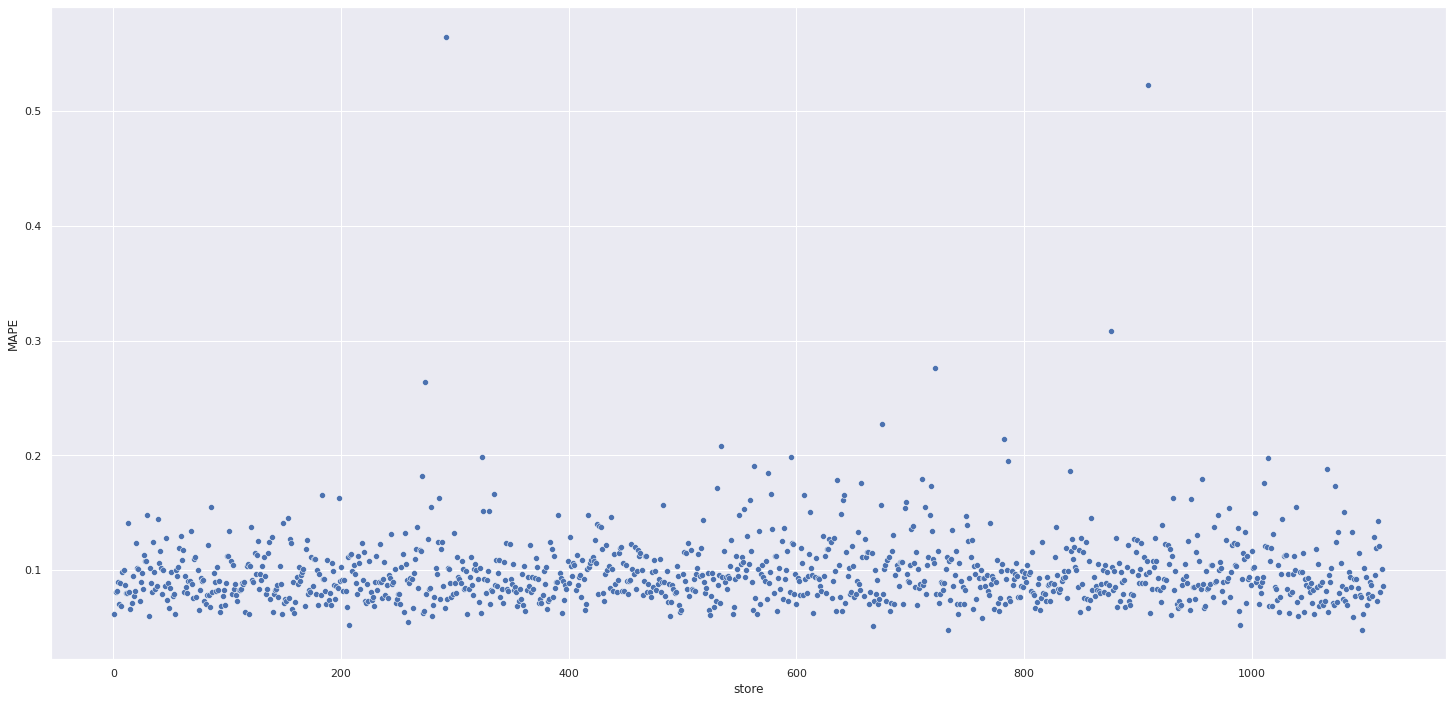

In [ ]:
sns.scatterplot(x='store', y='MAPE', data = df9_2)

### 8.2 Total Performance

In [ ]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns= {'index': 'Scenario', 0: 'Values' })
df9_3['Values'] = df9_3['Values'].map('R${:,.2f}'.format)
df9_3

,Scenario,Values
0,predictions,"R$286,738,496.00"
1,worst_scenario,"R$285,998,954.73"
2,best_scenario,"R$287,478,045.33"


### 8.3 Machine Learning Performance

In [ ]:
df9['error'] = df9['sales']-df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Dispersão dos erros')

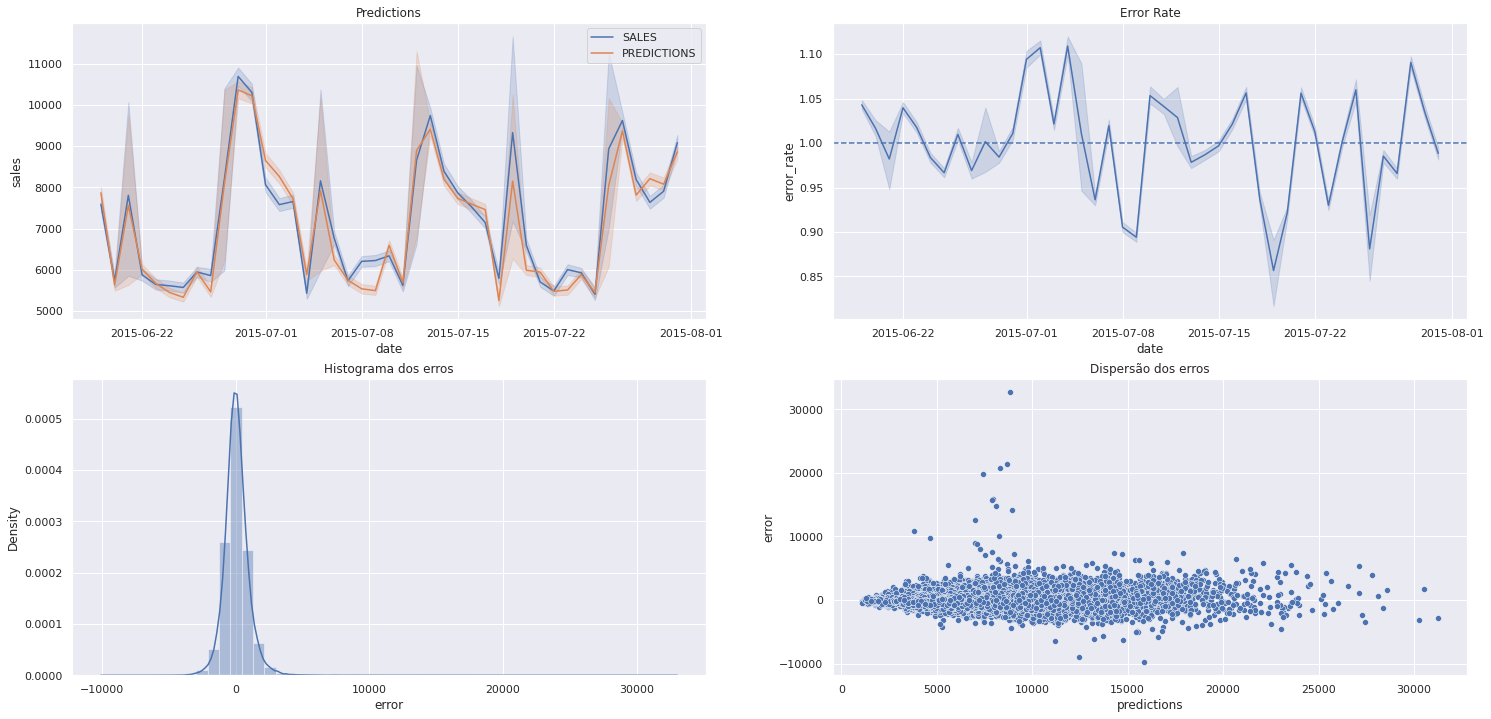

In [ ]:
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y='sales', data=df9, label='SALES')
sns.lineplot(x = 'date', y='predictions', data=df9, label='PREDICTIONS')
plt.title('Predictions')


plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.title('Error Rate')
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])
plt.title('Histograma dos erros')

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])
plt.title('Dispersão dos erros')

# 9.0 DEPLOY DO MODELO EM PRODUÇÃO

In [ ]:
#Usar o pickle para armazenar o modelo_xgb, o Rescaling das colunas, o tratamento dos dados em geral

### 9.1 Rossman Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
import json

class Rossmann (object):
  def __init__(self):
    self.competition_distance_scaler   = pickle.load(open('parameter/competition_distance_scaler.pkl', 'rb'))
    self.competition_time_month_scaler = pickle.load(open('parameter/competition_time_month_scaler.pkl', 'rb'))
    self.promo_time_week_scaler        = pickle.load(open('parameter/promo_time_week_scaler.pkl', 'rb'))
    self.year_scaler                   = pickle.load(open('parameter/year_scaler.pkl', 'rb'))
    self.store_type_scaler             = pickle.load(open('parameter/store_type_scaler.pkl', 'rb'))
  
  def data_cleaning(self, df1):
    # 1.1. Rename Columns
    cols_old = ['Store', 'DayOfWeek', 'Date', 'Open','Promo', 'StateHoliday', 'SchoolHoliday', 
                'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 
                'CompetitionOpenSinceYear','Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

    #Usando snakecase da biblioteca inflection:
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase,cols_old))

    #Renomeando: 
    df1.columns = cols_new

    #Transformando a coluna date para o tipo datetime:
    df1['date'] = pd.to_datetime(df1['date'])

    ### 1.5. Fillout NA

    #competition_distance
    df1['competition_distance'] = df1.competition_distance.apply(lambda x: 200000 if math.isnan(x) else x)

    #competition_open_since_month : 
    df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )

    #competition_open_since_year     
    df1.competition_open_since_year = df1.apply(lambda x: x.date.year if math.isnan(x.competition_open_since_year) else x.competition_open_since_year , axis = 1)
                                  
    #promo2_since_week            
    df1.promo2_since_week = df1.apply(lambda x: x.date.week if math.isnan(x.promo2_since_week) else x.promo2_since_week, axis = 1)

    #promo2_since_year    
    df1.promo2_since_year = df1.apply(lambda x: x.date.year if math.isnan(x.promo2_since_year) else x.promo2_since_year, axis = 1)

    #promo_interval: se não participar da promoção, colocar 0. Se participar, criar uma nova coluna indicando se está tendo uma promoção na data da linha   
    months_dic = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11:'Nov', 12: 'Dec'}

    df1.promo_interval.fillna(0, inplace = True)

    df1['month_map'] = df1.date.dt.month.map(months_dic)

    df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x.promo_interval == 0 else 1 if x.month_map in x.promo_interval.split(',') else 0,axis = 1)

    ### 1.6. Change Types
    df1.competition_open_since_month = df1.competition_open_since_month.astype(int)
    df1.competition_open_since_year = df1.competition_open_since_year.astype(int)

    df1.promo2_since_week = df1.promo2_since_week.astype(int)
    df1.promo2_since_year = df1.promo2_since_year.astype(int)

    return df1

  def feature_engineering(self, df2):

    # year
    df2['year'] = df2.date.dt.year
    #month
    df2['month'] = df2.date.dt.month
    #day
    df2['day'] = df2.date.dt.day
    #week of year
    df2['week_of_year'] = df2.date.dt.weekofyear
    #year week
    df2['year_week'] = df2.date.dt.strftime('%Y-%W')
    #competition since - tempo desde que a competição começou - Está separada em 2 colunas, precisamos uni-las
    df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'], day=1), axis = 1)
    df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

    #promo since - tempo desde que a promoção começou
    df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
    df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
    df2['promo_time_week'] = ((df2.date - df2.promo_since)/7).apply(lambda x: x.days).astype(int)
    #assortment
    df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x=='b' else 'extended')

    #state holiday
    df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

    # 2.5.1. Filtragem das Linhas
    df2 = df2[df2['open'] !=0]
    
    # 2.5.2. Seleção das colunas
    cols_drop=['open', 'promo_interval', 'month_map']
    df2 = df2.drop(cols_drop, axis=1)

    return df2

  def data_preparation(self,df5):
    ### 4.2 Rescaling
    #competition distance
    df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

    #competition time month
    df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
   
    #promo time week
    df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
    
    #year
    df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

    # 4.3.1 Encoding
    #state_holiday: one-hot encoding
    df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

    #store_type: label encoding
    df5['store_type']=self.store_type_scaler.fit_transform(df5['store_type'])

    #assortment: ordinal encoding
    assortment_dict = {'basic': 1,
                      'extra': 2,
                      'extended': 3
                      }
    df5['assortment'] = df5['assortment'].map(assortment_dict)

    # 4.3.3 Transformação de natureza
    #day of week
    df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
    df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

    #month - transformação cíclica
    df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
    df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

    #day
    df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
    df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

    #week of year
    df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
    df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

    cols_selected = ['assortment',  'competition_distance',  'competition_open_since_month',  'competition_open_since_year',
    'competition_time_month',  'day_sin',  'day_cos',  'day_of_week_cos',  'day_of_week_sin',  'month_sin',  'month_cos',  'promo',
    'promo2',  'promo2_since_week',  'promo2_since_year',  'promo_time_week',  'store',  'store_type',  'week_of_year_sin',
    'week_of_year_cos']


    return df5[cols_selected]

  def get_prediction(self,model, original_data, test_data):
    #prediction
    pred = model.predict(test_data)
    #join pred into the original data
    original_data['prediction'] = np.expm1(pred)

    return original_data.to_json(orient='records', date_format='iso')


### 9.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('model/model_xgb_tuned.pkl','rb'))

#initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST'])

def rossmann_predict():
  test_json = request.get_json()
  
  if test_json: #there is data

    if isinstance(test_json, dict): #unique example
      test_raw = pd.DataFrame(test_json, index=[0])

    else: #multiple examples
      test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

    #intanciar a rossmann class
    pipeline = Rossmann()
    
    #data cleaning
    df1 = pipeline.data_cleaning(test_raw)

    #feature engineering
    df2 = pipeline.feature_engineering(df1)

    #data preparation
    df3 = pipeline.data_preparation(df2)

    #prediction
    df_response = pipeline.get_prediction(model, test_raw, df3)

    return df_response

  else:
    return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
  port = os.environ.get('PORT',5000)
  app.run(host = '0.0.0.0', port = port)


### 9.3 Criando os arquivos

In [ ]:
#Criando pasta API - Usando o GIT !
#!mkdir -p api/rossman

In [ ]:
#cd /content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/api

In [ ]:
#!touch handler.py

In [ ]:
#cd rossmann

In [ ]:
#!touch Rossman.py

In [ ]:
#Editar os arquivos .py e colar os códigos dos snippets respectivos. 
#Executar !python handler.py em outro colab notebook
#copiar o endereço ngrok
#colar no API Tester

### 9.4 API Tester

In [ ]:
import requests

In [ ]:
df10 = pd.read_csv('/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/Dados/test.csv')

In [ ]:
#merge test df10 + store
df_test = pd.merge(df10,df_store_raw, how = 'left', on='Store')

#choose store 
df_test = df_test[df_test['Store'].isin([24,12,22])]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop(columns='Id')

In [ ]:
import json
#convert Df to JSON
data = json.dumps(df_test.to_dict(orient = 'records'))

In [ ]:
#API call
url = 'https://rossmann-test1.herokuapp.com/rossmann/predict'
#url = 'http://78f7b96dbbe8.ngrok.io/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers = header)
print('Status Code{}'.format(r.status_code))

Status Code200


In [ ]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [ ]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,5794.692383
1,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,3805.298340
2,24,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,7980.909180
3,12,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,5929.270996
4,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,3883.766602


In [ ]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
  print('Store number {} will sell R${:,.2f} in the next 6 weeks'.format(
      d2.loc[i,'store'], d2.loc[i, 'prediction']
  ))

Store number 12 will sell R$223,701.60 in the next 6 weeks
Store number 22 will sell R$139,371.96 in the next 6 weeks
Store number 24 will sell R$292,147.63 in the next 6 weeks


In [ ]:
d2

,store,prediction
0,12,223701.597168
1,22,139371.962524
2,24,292147.634766


### 9.5 Deploy no Heroku

#### No Colab:
- Criar uma pasta webapp, com as subpastas model, parameter, rossmann.
- Copiar modelo, parametros e handler para as pastas recém criadas.
- Criar arquivo Procfile: !touch Procfile
- pip freeze > requirements.txt (deixar apenas o que realmente usa)
- editar os arquivos handle, Rossmann e Procfile
- Dar o git push para salvar no github

#### No pc:
- Dar o git clone na pasta repos
- Instalar o Heroku CLI
- Abrir o Git Bash
- Entrar na pasta webapp pelo terminal
- git init
- heroku login
- git status
- git add .
- git commit -m 'initial commit'
- heroku apps:create nome-do-app
- git push heroku master
- Testar o modelo



In [ ]:
cd rossmann-telegram-api/

[Errno 2] No such file or directory: 'rossmann-telegram-api/'
/content/drive/My Drive/data_science/repos/Predict-Time-Series-Test/rossmann-telegram-api


In [ ]:
!touch rossman-bot.py

In [ ]:
!python rossmann-bot.py

Status Code200
Store number 22 will sell R$144,083.99 in the next 6 weeks


In [ ]:
ls -l

total 2
-rw------- 1 root root 1035 Oct 26 18:03 rossman-bot.py
